## MACHINE LEARNING EXAM -- CLASSIFICATION ALGORITHMS WITH SKLEARN IN PYTHON
- Author : Simone Benzi

## PROJECT GOAL AND DATASET DESCRIPTION

In this project, you will take the role of a data scientist in an insurance company. Your task is to build a machine learning model able to predict the severity of a crash. A crash is described by the following set of features:

'RD_NO' : Road number, 

'CRASH_DATE': crash date, 

'POSTED_SPEED_LIMIT' :  speed limit of the street, 

'TRAFFIC_CONTROL_DEVICE' : type of traffic control devive presents on the street ,

'DEVICE_CONDITION': condition of the traffic device control (e.g. functional traffic light), 

'WEATHER_CONDITION': weather condition, 

'LIGHTING_CONDITION': illumination condition,

'FIRST_CRASH_TYPE': crash dynamics (e.g. crash with a parked vehicle etc...) , 

'TRAFFICWAY_TYPE': type of street (e.g a roundabout ect..), 

'ALIGNMENT': type of manouver,

'ROADWAY_SURFACE_COND': street condition, 

'ROAD_DEFECT': street defect, 

'REPORT_TYPE': report type, 

'CRASH_TYPE': crash type,

'DAMAGE': level of demage, 

'DATE_POLICE_NOTIFIED' : date when police where notified, 

'PRIM_CONTRIBUTORY_CAUSE': Primary cause of the crash,

'SEC_CONTRIBUTORY_CAUSE': Secondary cause of the crash, 

'STREET_NO': street number, 

'STREET_DIRECTION': street direction,

'STREET_NAME' : street name, 

'BEAT_OF_OCCURRENCE': number of crash in that area, 

'NUM_UNITS': number of vehicles  involved in the crash, 

'INJURIES_TOTAL': total number of injuries,

'INJURIES_FATAL': total number of fatal injuries, 

'LATITUDE': latitude of the crash, 

'LONGITUDE': longitude of the crash

The dataset lacks of a "crash severity" column, you will have to build your own outcome column (the y of our exercises) from the available ones and determine if a classification or regression is more suited for this problem. You can decide, based on some rules or motivations, whether to use all the features or only a subset of the

In [2]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import shap
import xgboost as xgb
import sweetviz


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict, cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#loading the data 
data = pd.read_csv('C:/Users/simob/Desktop/Data/Dati_esame_ML.csv', sep=';')

In [43]:
data.head(5)

RD_NO              CRASH_DATE  POSTED_SPEED_LIMIT  \
0  JC199175  03/25/2019 03:00:00 AM                15.0   
1  JG241110  04/28/2023 07:20:00 PM                30.0   
2  HZ455030  09/29/2016 08:25:00 AM                30.0   
3  JD423820        11/07/2020 09:30                30.0   
4  JE149629  02/23/2021 09:30:00 AM                30.0   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS           NO CONTROLS             CLEAR   
1            NO CONTROLS           NO CONTROLS             CLEAR   
2                    NaN           NO CONTROLS              RAIN   
3         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
4      STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   

  LIGHTING_CONDITION          FIRST_CRASH_TYPE TRAFFICWAY_TYPE  \
0           DAYLIGHT                  REAR END         ONE-WAY   
1               DAWN      PARKED MOTOR VEHICLE         ONE-WAY   
2           DAYLIGHT      PARKED MOTOR VEHICLE     PARKING LOT   
3           DAYLIGHT  SIDESWIPE SAME DIRECTION     NOT DIVIDED   
4                NaN                     ANGLE     NOT DIVIDED   

            ALIGNMENT  ...                  SEC_CONTRIBUTORY_CAUSE STREET_NO  \
0  STRAIGHT AND LEVEL  ...                     UNABLE TO DETERMINE    4201.0   
1  STRAIGHT AND LEVEL  ...                                     NaN    1326.0   
2  STRAIGHT AND LEVEL  ...                     UNABLE TO DETERMINE    7674.0   
3  STRAIGHT AND LEVEL  ...  FAILING TO REDUCE SPEED TO AVOID CRASH     510.0   
4  STRAIGHT AND LEVEL  ...                                     NaN    6000.0   

  STREET_DIRECTION      STREET_NAME BEAT_OF_OCCURRENCE NUM_UNITS  \
0                W              NaN             1731.0         2   
1                N  SPRINGFIELD AVE             2535.0         2   
2                S   SOUTH SHORE DR              421.0         2   
3                E         115TH ST              531.0         2   
4                W     CORNELIA AVE             1633.0         2   

  INJURIES_TOTAL INJURIES_FATAL        LATITUDE        LONGITUDE  
0            1.0            0.0  41.941.649.437  -87.732.229.008  
1            0.0            0.0  41.905.143.969  -87.724.090.302  
2            0.0            0.0  41.757.094.832  -87.553.728.772  
3            0.0            0.0  41.685.556.581  -87.610.930.649  
4            0.0            0.0  41.944.051.024  -87.776.552.798  

[5 rows x 27 columns]

CREATE THE VARIABLE TO PREDICT --> "CRASH SEVERITY"

Let's create the variable we have to predict, the 'crash severity' based on injuries total and injuries fatal columns. This will be our target variable 'Y'.

The main idea is to set up two classes: low = 0 and high = 1. 
-) If there is no injuries, namely INJ_TOTAL = 0 and INJ_FATAL = 0 then we classify the crash as low = 0.
-) Conversely, when we have at least an injuries, that may be fatal or not, we classify the crash as high = 1.
-) Therefore our task is to carry out a binary classification.

Indeed we are going to remove those features from the dataset, otherwise the model would be perfect, which is trivially not meaningful.

In [4]:
#remove missing values and convert the cols as float before create the new col
data['INJURIES_FATAL'].dropna(inplace = True)
data['INJURIES_TOTAL'].dropna(inplace = True)

data['INJURIES_TOTAL'] = data['INJURIES_TOTAL'].astype(float)
data['INJURIES_FATAL'] = data['INJURIES_FATAL'].astype(float)
print(data['INJURIES_FATAL'].dtype)

float64


In [5]:
#define the function to create the new variable to predict
# 0 is low intensity
# 1 is high intensity

def severity(INJURIES_TOTAL,INJURIES_FATAL):
    if INJURIES_TOTAL== 0 and INJURIES_FATAL== 0:
        return 0                    
    else:
        return 1  

In [6]:
data['CRASH SEVERITY'] = data.apply(lambda x: severity( x['INJURIES_TOTAL'], x['INJURIES_FATAL']), axis=1)
data.head(5)

RD_NO              CRASH_DATE  POSTED_SPEED_LIMIT  \
0  JC199175  03/25/2019 03:00:00 AM                15.0   
1  JG241110  04/28/2023 07:20:00 PM                30.0   
2  HZ455030  09/29/2016 08:25:00 AM                30.0   
3  JD423820        11/07/2020 09:30                30.0   
4  JE149629  02/23/2021 09:30:00 AM                30.0   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS           NO CONTROLS             CLEAR   
1            NO CONTROLS           NO CONTROLS             CLEAR   
2                    NaN           NO CONTROLS              RAIN   
3         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
4      STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   

  LIGHTING_CONDITION          FIRST_CRASH_TYPE TRAFFICWAY_TYPE  \
0           DAYLIGHT                  REAR END         ONE-WAY   
1               DAWN      PARKED MOTOR VEHICLE         ONE-WAY   
2           DAYLIGHT      PARKED MOTOR VEHICLE     PARKING LOT   
3           DAYLIGHT  SIDESWIPE SAME DIRECTION     NOT DIVIDED   
4                NaN                     ANGLE     NOT DIVIDED   

            ALIGNMENT  ... STREET_NO STREET_DIRECTION      STREET_NAME  \
0  STRAIGHT AND LEVEL  ...    4201.0                W              NaN   
1  STRAIGHT AND LEVEL  ...    1326.0                N  SPRINGFIELD AVE   
2  STRAIGHT AND LEVEL  ...    7674.0                S   SOUTH SHORE DR   
3  STRAIGHT AND LEVEL  ...     510.0                E         115TH ST   
4  STRAIGHT AND LEVEL  ...    6000.0                W     CORNELIA AVE   

  BEAT_OF_OCCURRENCE NUM_UNITS INJURIES_TOTAL INJURIES_FATAL        LATITUDE  \
0             1731.0         2            1.0            0.0  41.941.649.437   
1             2535.0         2            0.0            0.0  41.905.143.969   
2              421.0         2            0.0            0.0  41.757.094.832   
3              531.0         2            0.0            0.0  41.685.556.581   
4             1633.0         2            0.0            0.0  41.944.051.024   

         LONGITUDE CRASH SEVERITY  
0  -87.732.229.008              1  
1  -87.724.090.302              0  
2  -87.553.728.772              0  
3  -87.610.930.649              0  
4  -87.776.552.798              0  

[5 rows x 28 columns]

In [7]:
#percentage of crash severity into the dataset
data['CRASH SEVERITY'].value_counts()/len(data['CRASH SEVERITY'])

0    0.862219
1    0.137781
Name: CRASH SEVERITY, dtype: float64

A FIRST GLIMPSE TO THE DATASET

EXPLORATORY ANALYSIS: Sweetviz (library built on top of Pandas that provides automated visualization for EDA) provides a quick and comprehensive way to visualize and understand the distribition of the features, facilitating the identification of missing values and data structure, thus expediting the data exploration process. To further investigate the data, one can click on the name of the feature to gain more insights about them, this is useful for feature selection. 

In [48]:
#data type, missing value and data structure
data.info(), data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97045 entries, 0 to 97044
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RD_NO                    96463 non-null  object 
 1   CRASH_DATE               85767 non-null  object 
 2   POSTED_SPEED_LIMIT       93048 non-null  float64
 3   TRAFFIC_CONTROL_DEVICE   79246 non-null  object 
 4   DEVICE_CONDITION         97045 non-null  object 
 5   WEATHER_CONDITION        86432 non-null  object 
 6   LIGHTING_CONDITION       82524 non-null  object 
 7   FIRST_CRASH_TYPE         97045 non-null  object 
 8   TRAFFICWAY_TYPE          83660 non-null  object 
 9   ALIGNMENT                97045 non-null  object 
 10  ROADWAY_SURFACE_COND     97045 non-null  object 
 11  ROAD_DEFECT              86377 non-null  object 
 12  REPORT_TYPE              94225 non-null  object 
 13  CRASH_TYPE               97045 non-null  object 
 14  DAMAGE                

(None,
 RD_NO                      96463
 CRASH_DATE                 79901
 POSTED_SPEED_LIMIT            32
 TRAFFIC_CONTROL_DEVICE        19
 DEVICE_CONDITION               8
 WEATHER_CONDITION             12
 LIGHTING_CONDITION             6
 FIRST_CRASH_TYPE              18
 TRAFFICWAY_TYPE               20
 ALIGNMENT                      6
 ROADWAY_SURFACE_COND           7
 ROAD_DEFECT                    7
 REPORT_TYPE                    3
 CRASH_TYPE                     2
 DAMAGE                         3
 DATE_POLICE_NOTIFIED       92808
 PRIM_CONTRIBUTORY_CAUSE       40
 SEC_CONTRIBUTORY_CAUSE        40
 STREET_NO                   8298
 STREET_DIRECTION               4
 STREET_NAME                 1297
 BEAT_OF_OCCURRENCE           274
 NUM_UNITS                     11
 INJURIES_TOTAL                14
 INJURIES_FATAL                 4
 LATITUDE                   56956
 LONGITUDE                  60592
 CRASH SEVERITY                 2
 dtype: int64)

                                             |          | [  0%]   00:00 -> (? left)


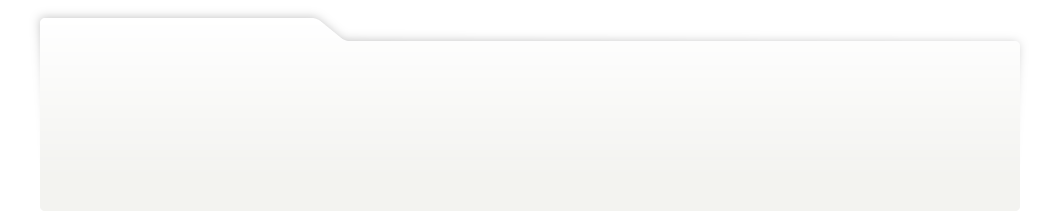
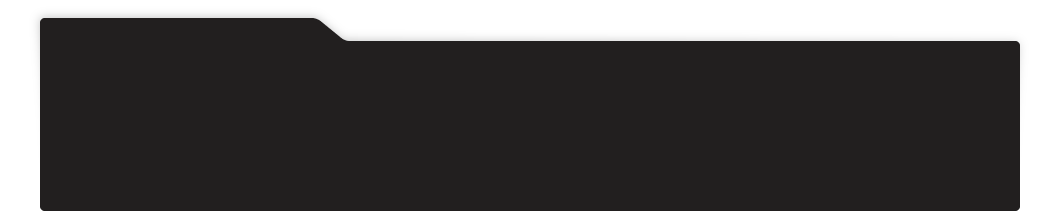
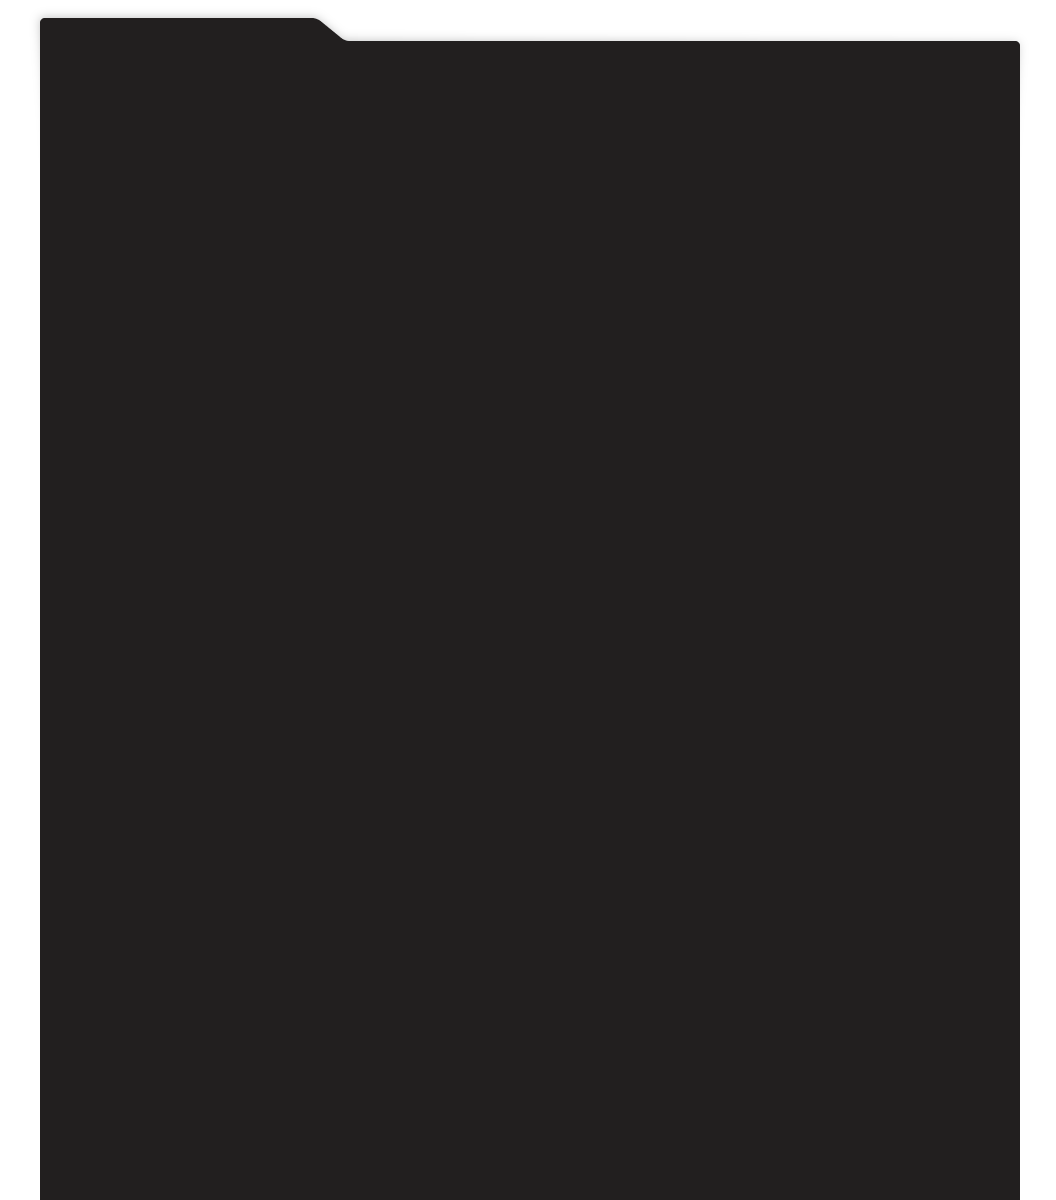
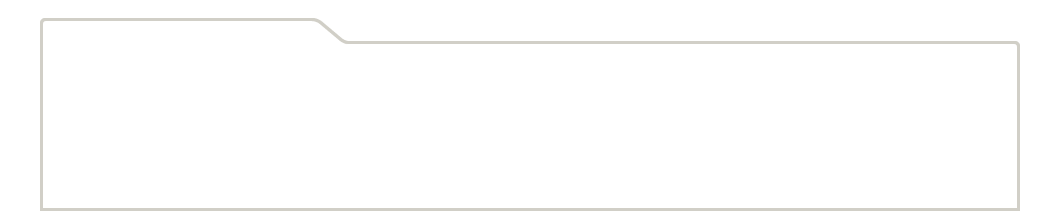
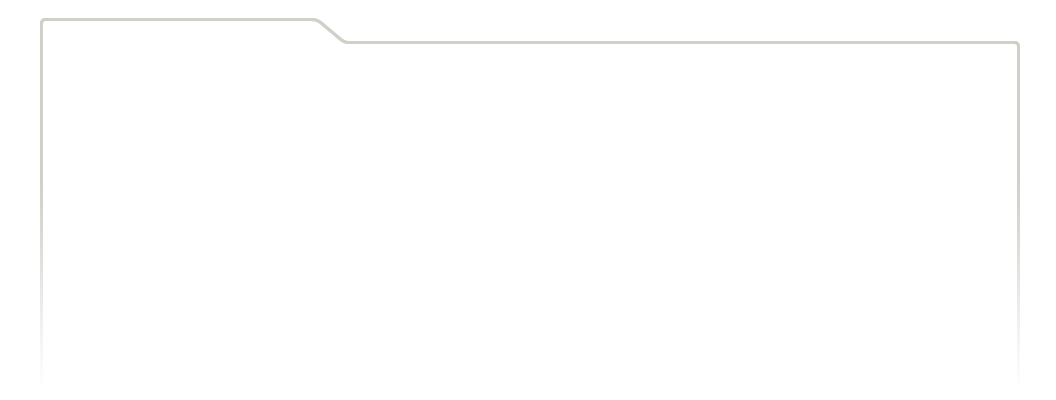
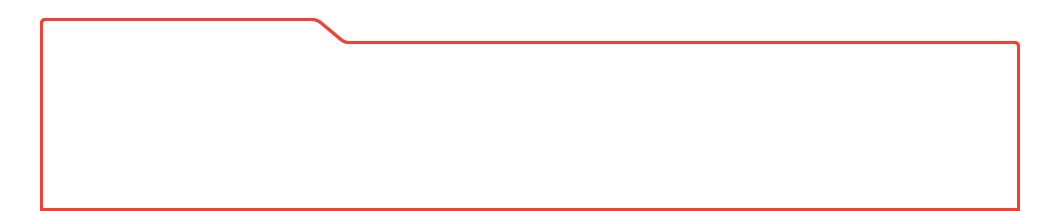
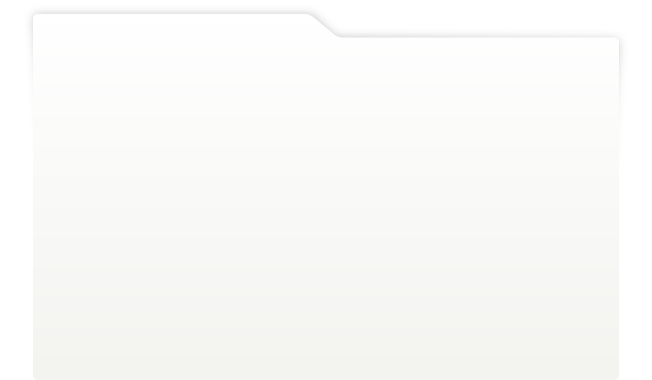
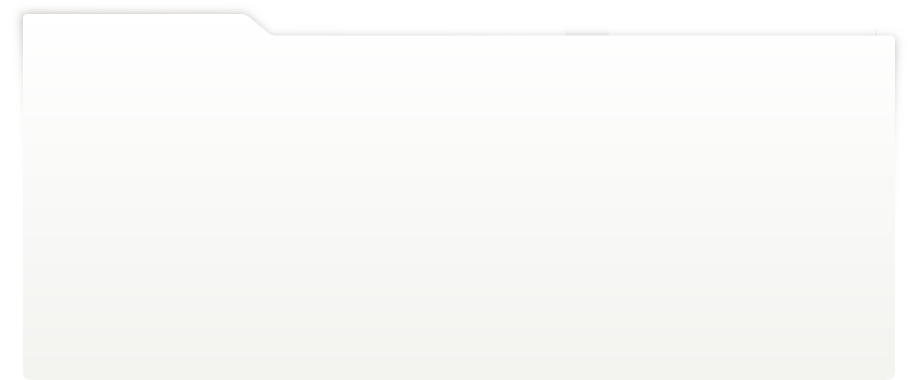
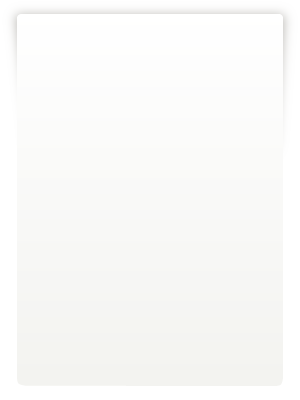
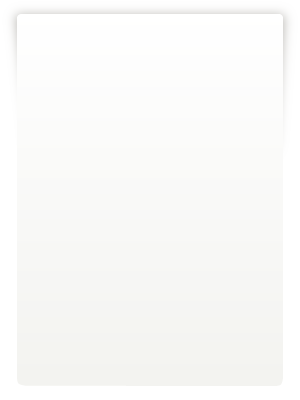
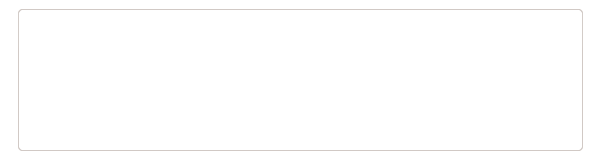
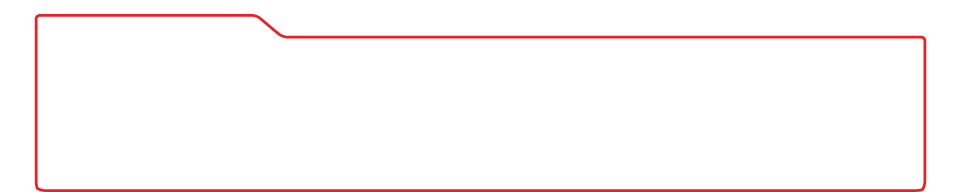
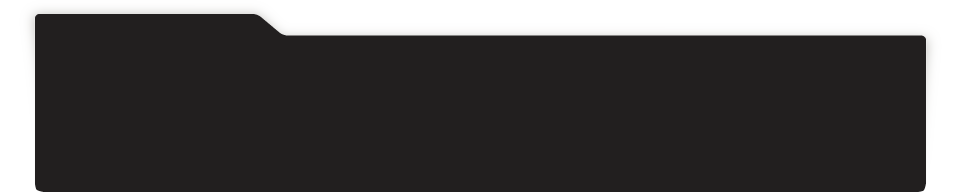
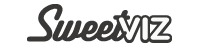
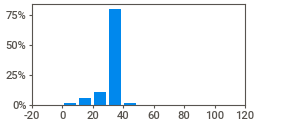
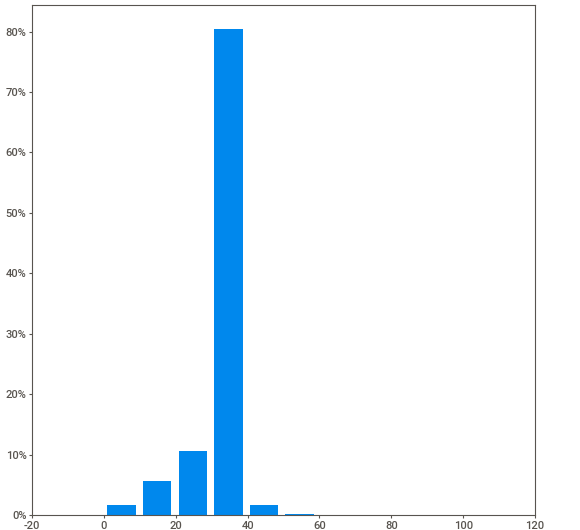
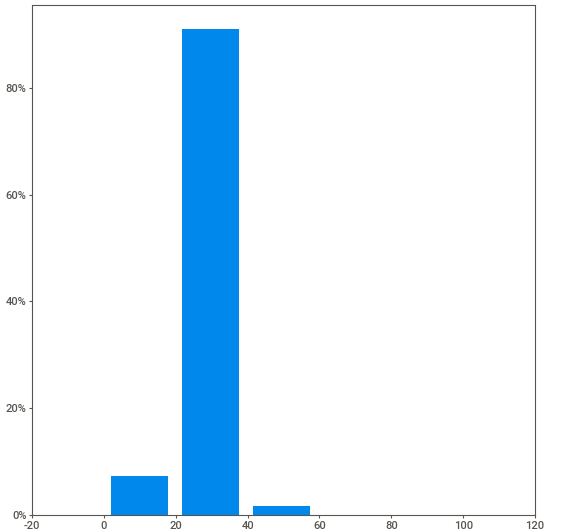
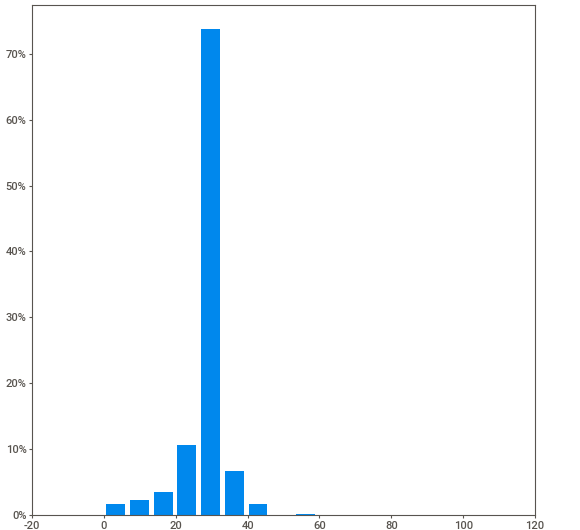
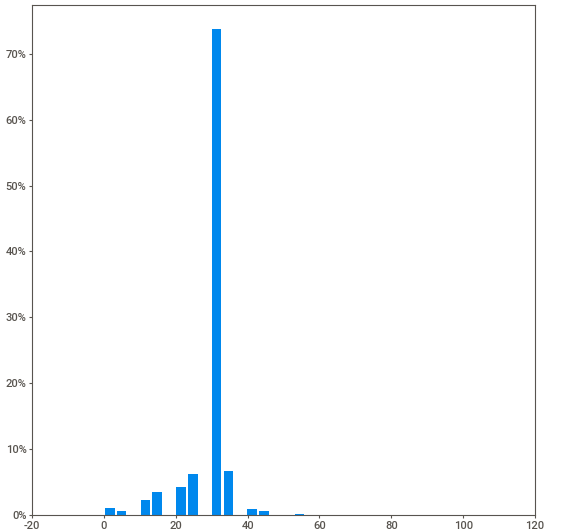
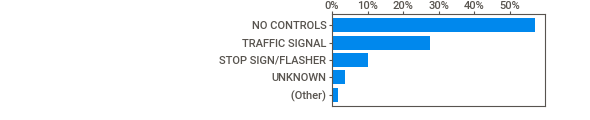
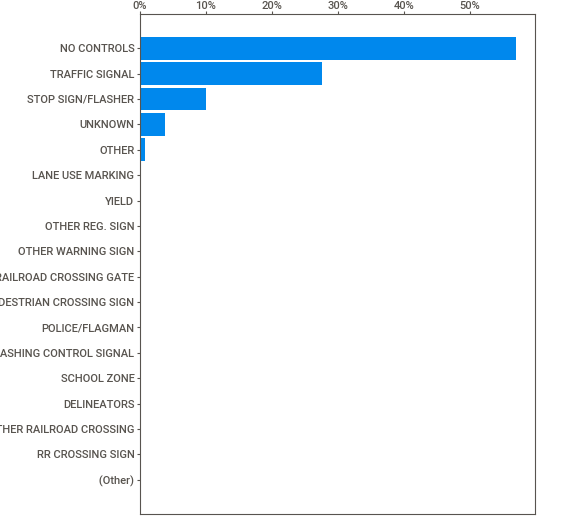
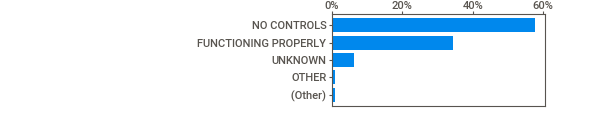
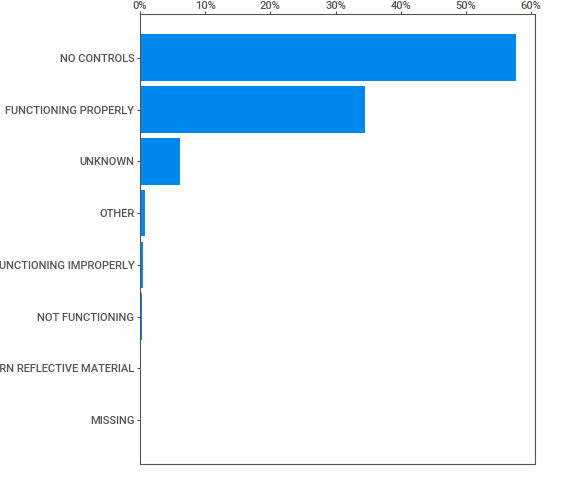
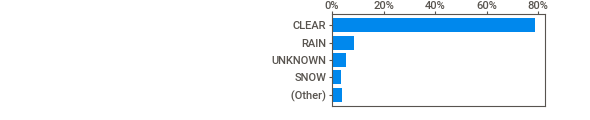
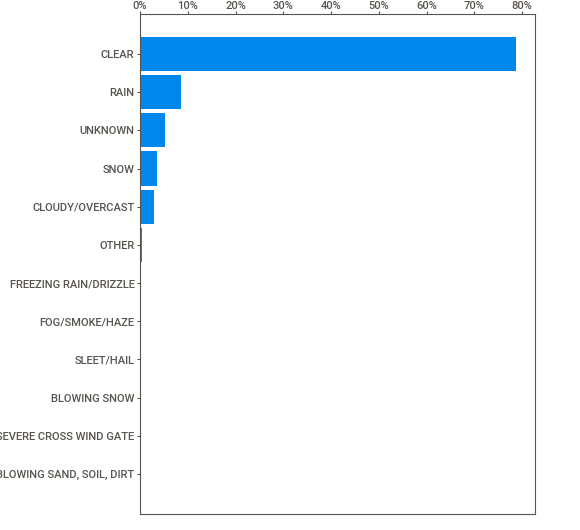
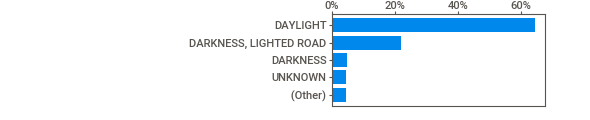
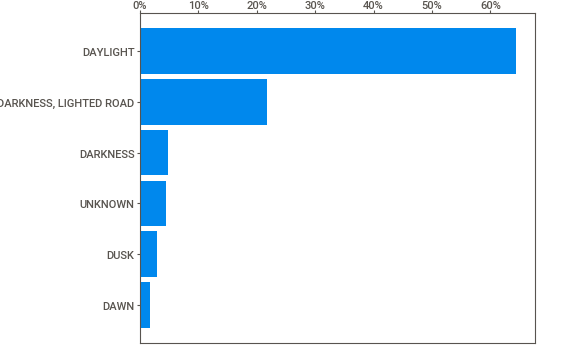
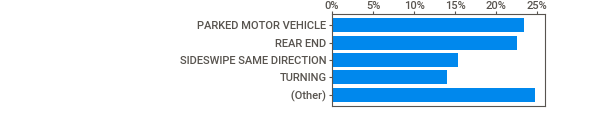
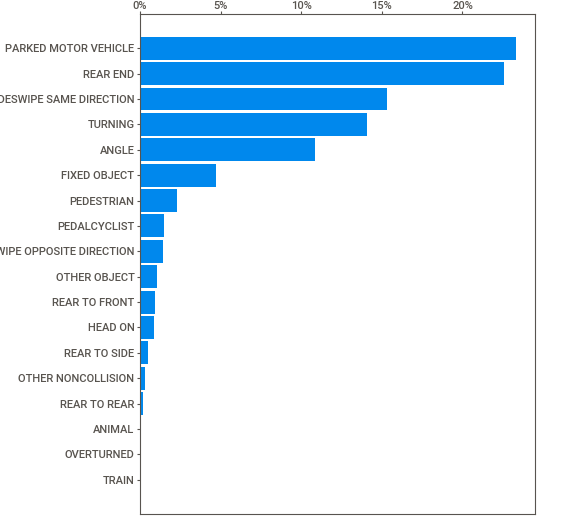
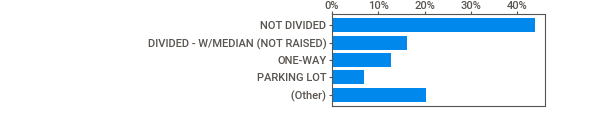
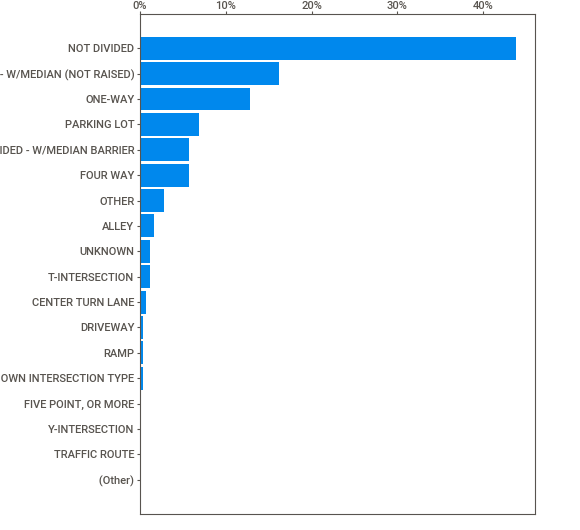
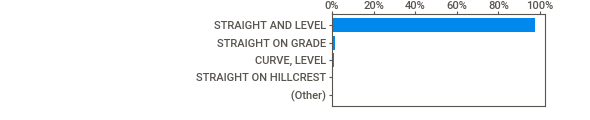
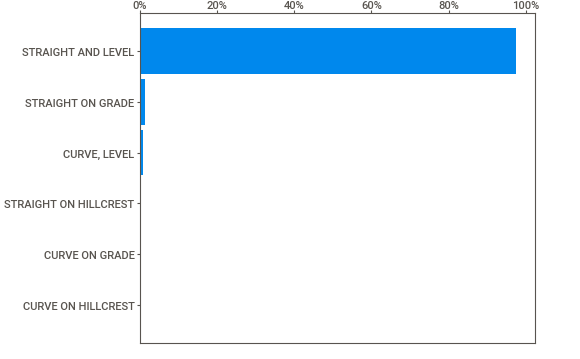
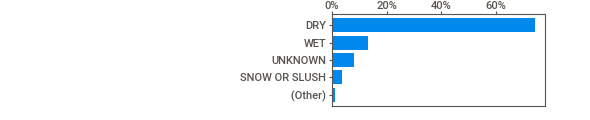
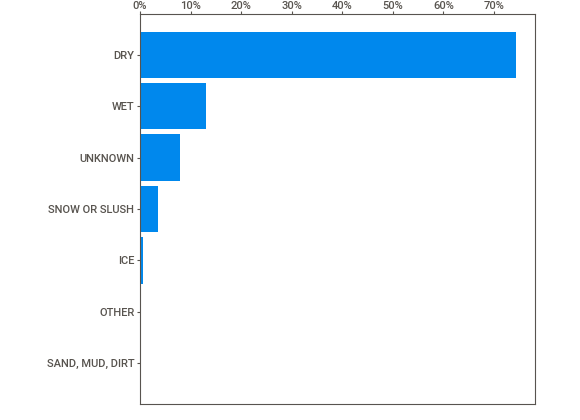
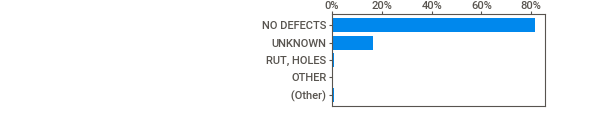
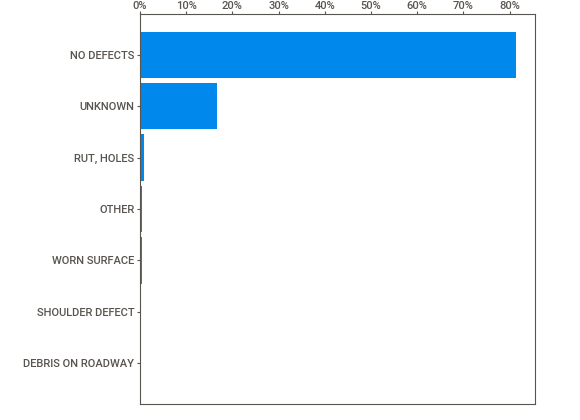
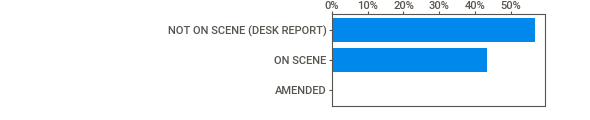
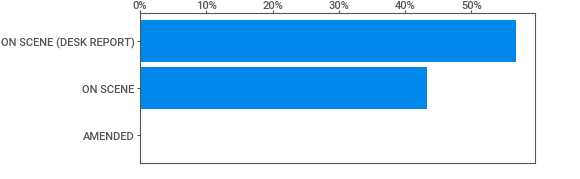
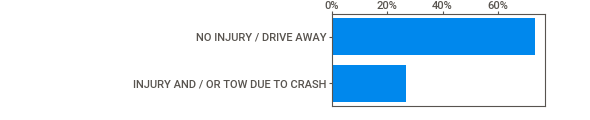
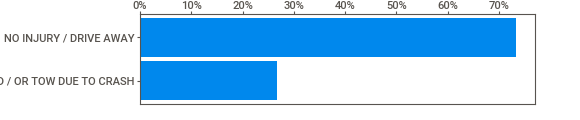
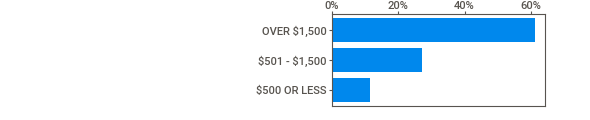
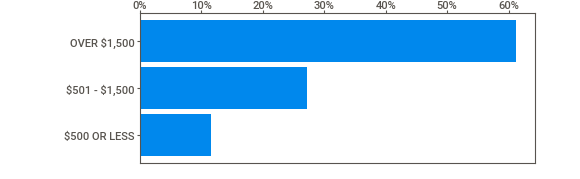
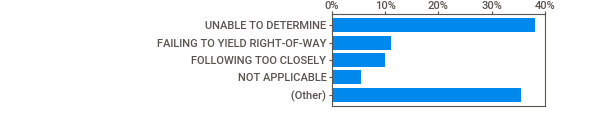
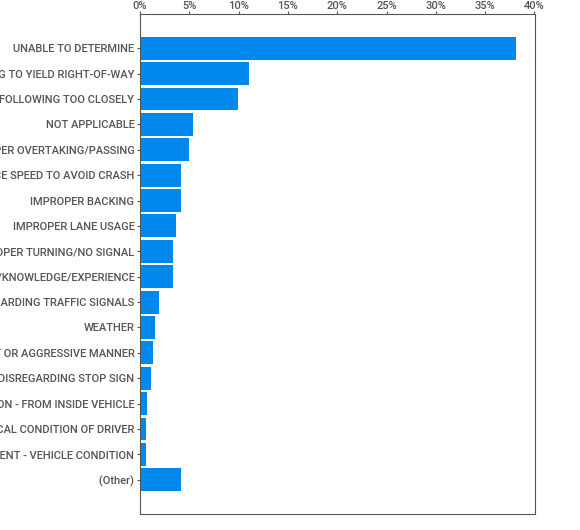
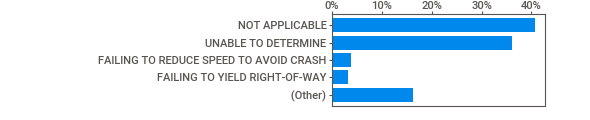
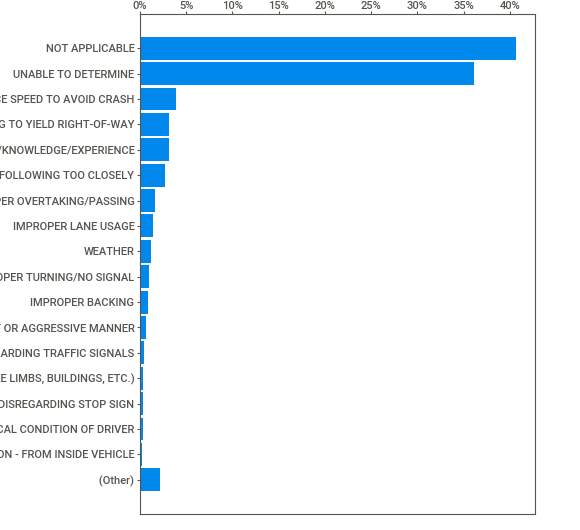
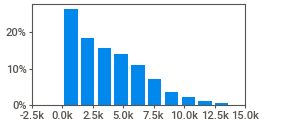
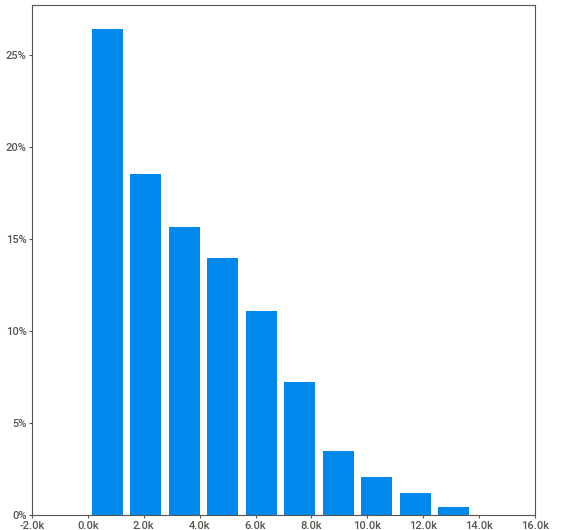
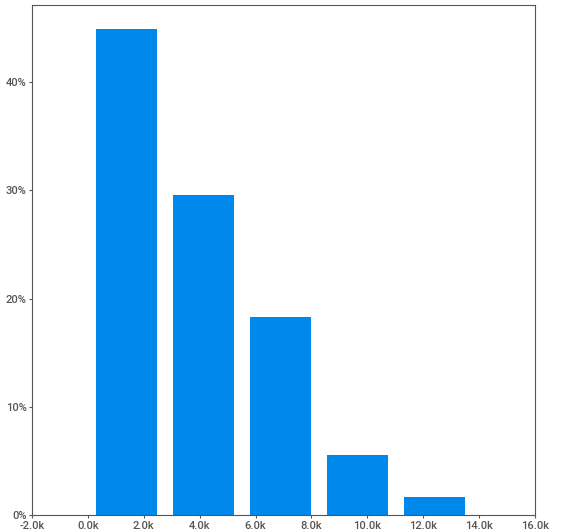
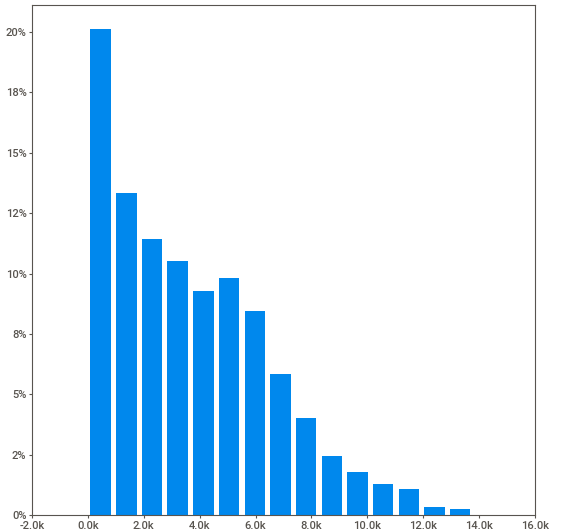
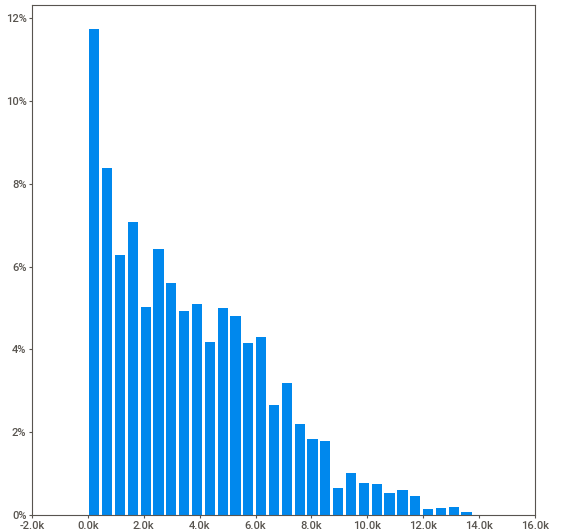
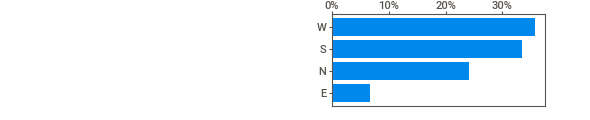
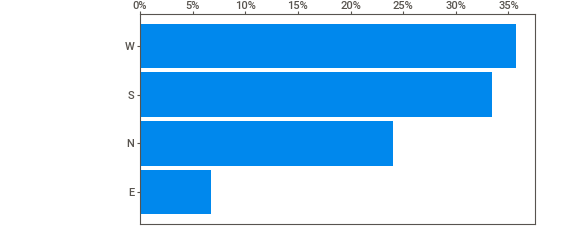
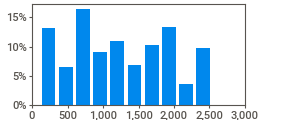
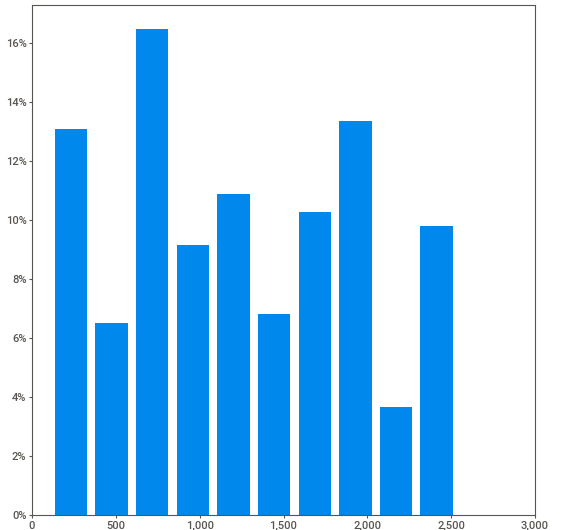
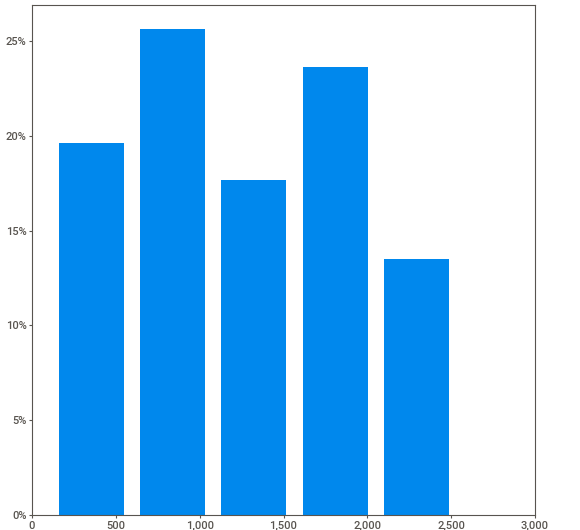
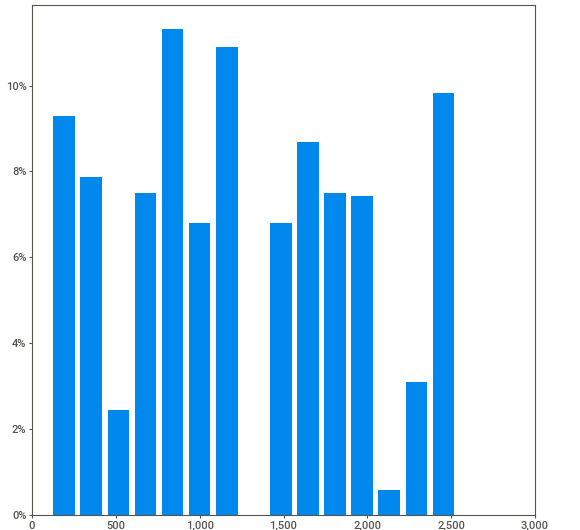
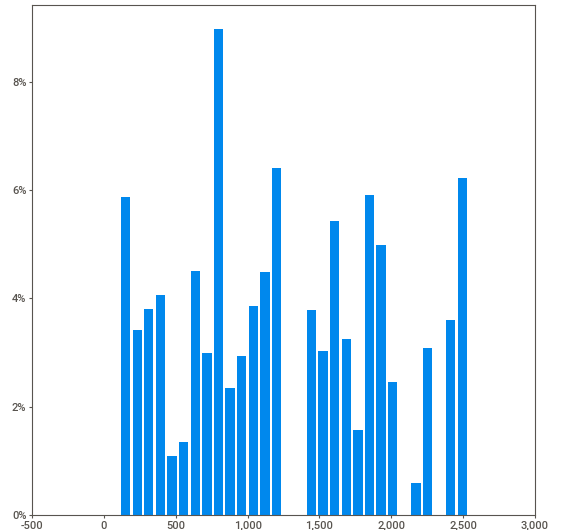
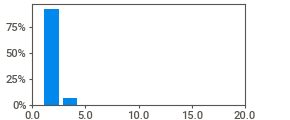
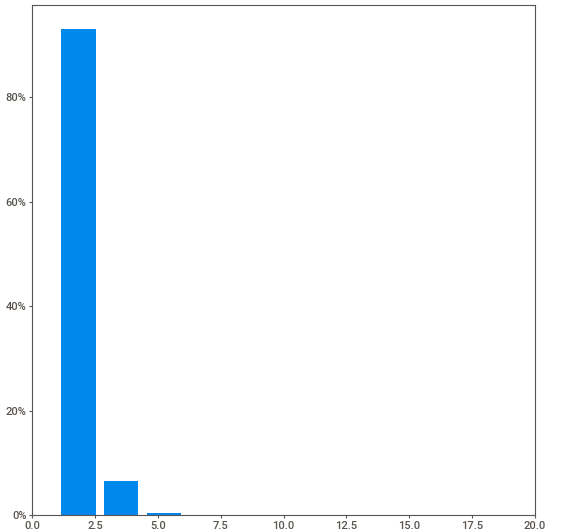
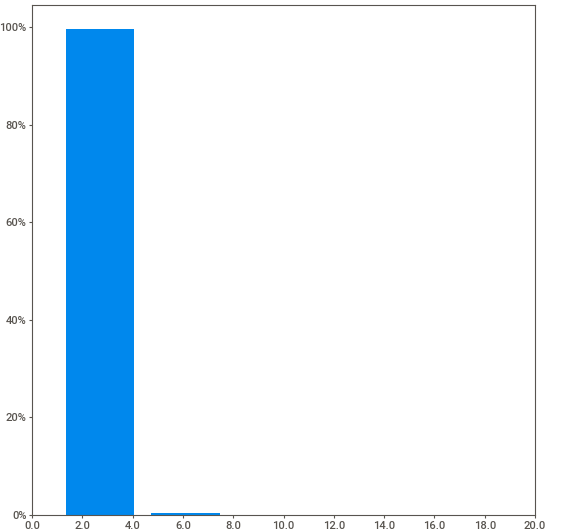
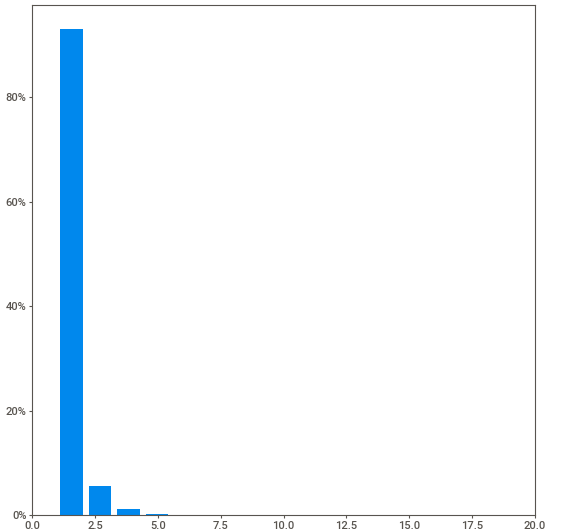
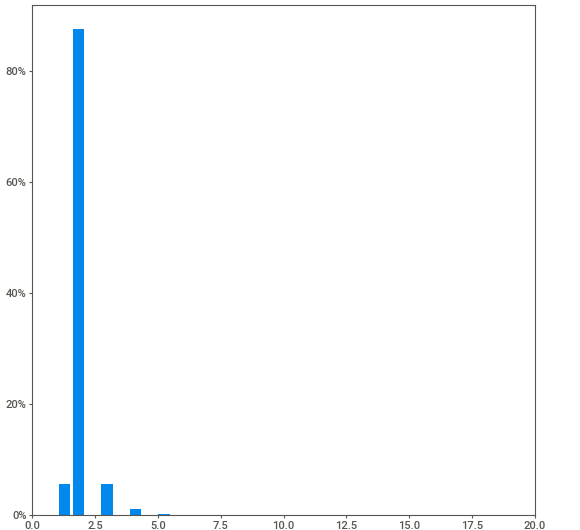
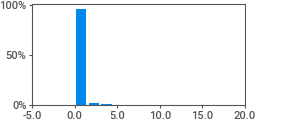
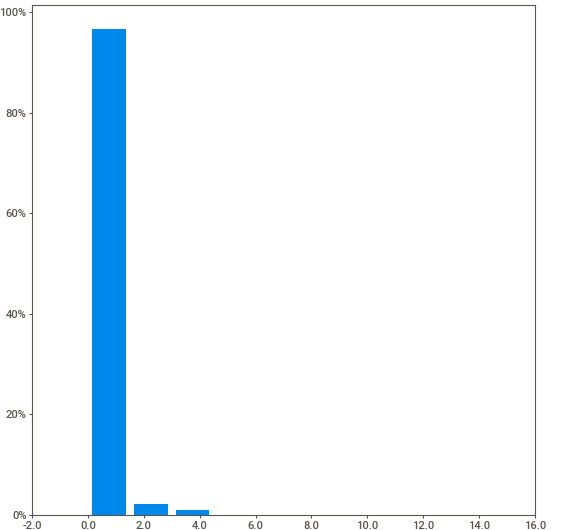
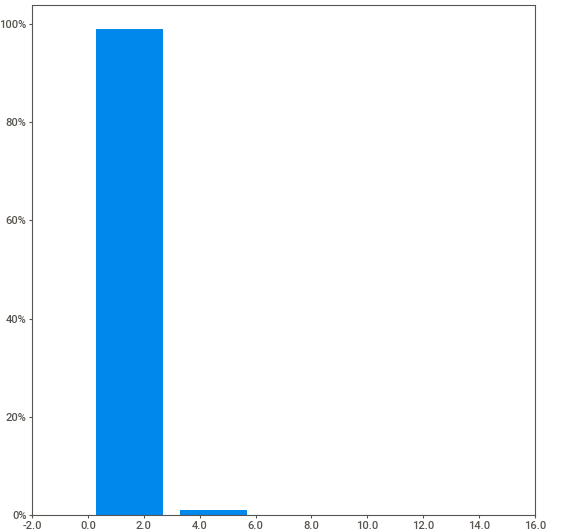
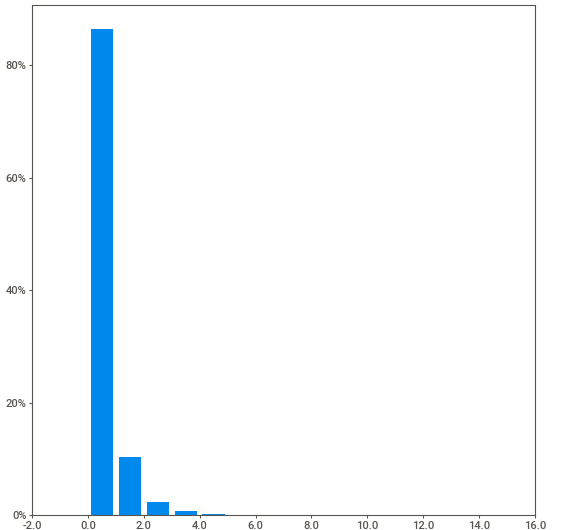
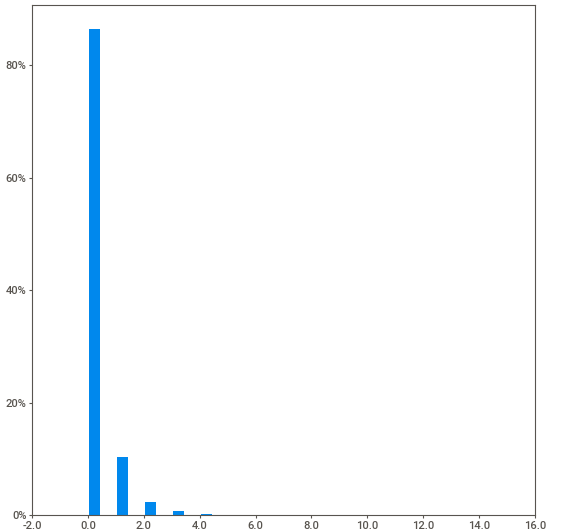
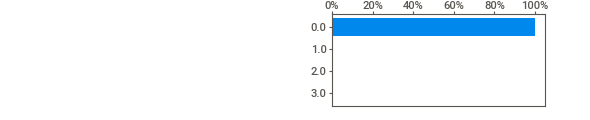
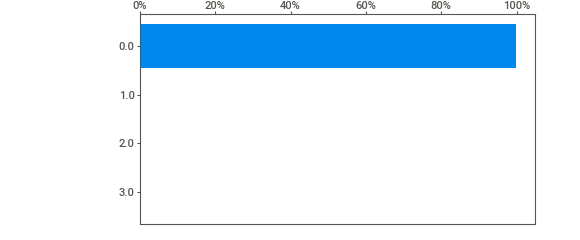
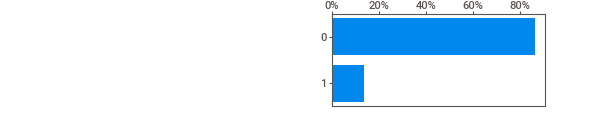
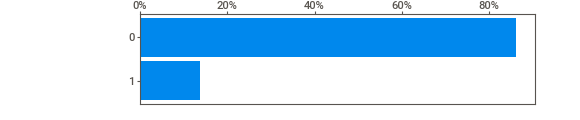
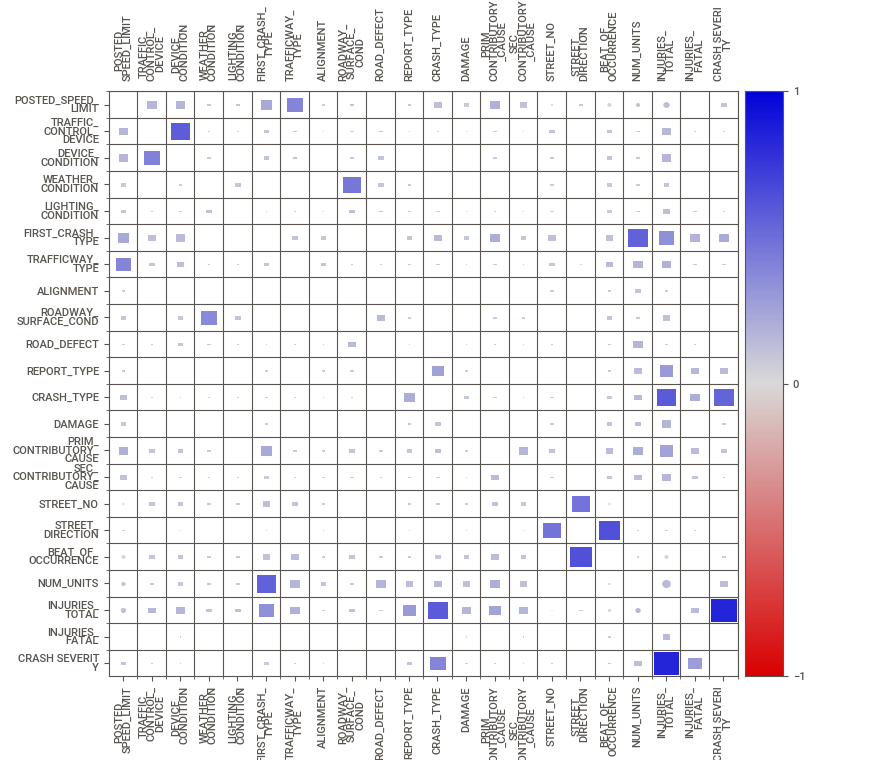
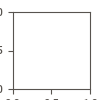

In [49]:
#data structure and distribution
report = sweetviz.analyze(data)
report.show_notebook()

### DATA PREPROCESSING 

Throughout this course we have learnt the powerful of Sikit-learn. Once you have clear in your mind the math behind the model and its intuition, the library makes the bulk of the work for us. In my view, this point out that the Data Cleaning and Feature selction process are paramount to have a robust model. 
<br>
<br>

1) **DATA CLEANING** : I made a copy of the original dataset and lowered case the col names, then I dropped the missing values. Factoring out missing values creates a robust model, although we pay the price of loss some information. In this case the number of rows changed roughly from 97.0000 to 19.000. It's about loosing 80% of the orginal data.

 - Yet, we can do a better job. We could retain more data. Why is it so?
  The reason is that if we would use .dropna() at the beginning, we will eliminate some extra rows since some missing values arise from columns that are not useful at all.
  Therefore, at first we'll get rid of some useless features based on cause-effect relationship and data structure, then we divide numerical and categorical features, and with the aid of pearson correlation matrix and pairplot we'll consider just the most relavant feature. At this point we use .dropna(). 

<br>

2) **FEATURE SELECTION**: Out of 27 features, which ones shuold I employ in my models?

   Feature selection is a critical part of data preprocessing in machine learning, focused on identifying and retaining the most relevant variables from a dataset while discarding redundant or irrelevant ones. I recall that the type of data are : 16 categorical, 5 numerical and 6 text.
   The main idea is to get rid of cols that have no cause and effect relationship with the crash severity, the ones that are constant and those hihgly correlated.

   Initially, I've removed this 15 columns (hence we must leave 12 cols) through  Domain Business Knownledge: 

- a) I reckon 'crash date', 'date policy notified', 'report type' has no direct influence on the severity of the crash. 
- b) Total and Fatal injuries since have been used to build the variable to predict
- c) From Sweetviz we can see 'RD_NO', 'street no', 'street name', 'prim_contributory_cause', 'latitude', 'longitude' have too many different values that are difficult to encode
- d) 'road defect', 'second_contributory_cause' and 'alignment' are redundant
<br>

  
  According to the theory, for the sake of model coherence and to avoid *Data Leakage* we precise we carry out *only* with training data *(X_train)*.
  At this point we further explore our data with:
  - *correlation matrices*
  - *specific plot distribution* 
  - *histograns of features wrt target variable*

  And with the aid of Sweetviz we infer:
  1. Basically, there are no ouliers that can inflate our models, especially the Logic Regression. This it's underpinned by the fact the bulk of the features is categorical.
  2. We do not perform 'variance threshold filtering' since there is no feature that has quasi zero variance seemingly.
  3. All the numerical features considered are not correlated to each other, this prevent for multicollinearity
  4. From the hist of the features wrt the categorical variables we can see the features has suffient variance and an impact on crash severity, ie the target variable

In [8]:
#Let's make a copy ancd clean the data set
df=data.copy()

#lower case the cols 
df.columns = (col.lower() for col in df)

#Remove missing data and check the shape 

df.dropna(inplace= True)
print("Data shape: {}, About 80% of initial data is missing if I apply dropna at the beginning".format((data.shape,df.shape)))
print( df.isnull().sum())



Data shape: ((97045, 28), (18876, 28)), About 80% of initial data is missing if I apply dropna at the beginning
rd_no                      0
crash_date                 0
posted_speed_limit         0
traffic_control_device     0
device_condition           0
weather_condition          0
lighting_condition         0
first_crash_type           0
trafficway_type            0
alignment                  0
roadway_surface_cond       0
road_defect                0
report_type                0
crash_type                 0
damage                     0
date_police_notified       0
prim_contributory_cause    0
sec_contributory_cause     0
street_no                  0
street_direction           0
street_name                0
beat_of_occurrence         0
num_units                  0
injuries_total             0
injuries_fatal             0
latitude                   0
longitude                  0
crash severity             0
dtype: int64


In [9]:
#let's define another copy of the dataset
df1 = data.copy()
df1.columns = (col.lower() for col in df)
df1.head(3)

rd_no              crash_date  posted_speed_limit  \
0  JC199175  03/25/2019 03:00:00 AM                15.0   
1  JG241110  04/28/2023 07:20:00 PM                30.0   
2  HZ455030  09/29/2016 08:25:00 AM                30.0   

  traffic_control_device device_condition weather_condition  \
0            NO CONTROLS      NO CONTROLS             CLEAR   
1            NO CONTROLS      NO CONTROLS             CLEAR   
2                    NaN      NO CONTROLS              RAIN   

  lighting_condition      first_crash_type trafficway_type  \
0           DAYLIGHT              REAR END         ONE-WAY   
1               DAWN  PARKED MOTOR VEHICLE         ONE-WAY   
2           DAYLIGHT  PARKED MOTOR VEHICLE     PARKING LOT   

            alignment  ... street_no street_direction      street_name  \
0  STRAIGHT AND LEVEL  ...    4201.0                W              NaN   
1  STRAIGHT AND LEVEL  ...    1326.0                N  SPRINGFIELD AVE   
2  STRAIGHT AND LEVEL  ...    7674.0                S   SOUTH SHORE DR   

  beat_of_occurrence num_units injuries_total injuries_fatal        latitude  \
0             1731.0         2            1.0            0.0  41.941.649.437   
1             2535.0         2            0.0            0.0  41.905.143.969   
2              421.0         2            0.0            0.0  41.757.094.832   

         longitude crash severity  
0  -87.732.229.008              1  
1  -87.724.090.302              0  
2  -87.553.728.772              0  

[3 rows x 28 columns]

In [10]:
#drop the columns using Domain Business Knowledge 
col_to_cancel = ['crash_date', 'date_police_notified', 'report_type', 'injuries_total','injuries_fatal', 
                 'rd_no', 'street_no', 'street_name', 'latitude', 'longitude','road_defect','alignment',
                 'prim_contributory_cause','sec_contributory_cause','street_direction' ]

df_dropped = df1.drop(col_to_cancel, axis = 1)

#using dropna after feature selection allows us to retain more data
df_dropped.dropna(inplace= True), 
print("Data shape: {}, Removing Nan after having dropped irrelevant columns allowed us to pass from 19k to 50k of data rows".format((df.shape,df_dropped.shape)))



Data shape: ((18876, 28), (49565, 13)), Removing Nan after having dropped irrelevant columns allowed us to pass from 19k to 50k of data rows


In [11]:
#Separate the target variable from the 
y = df_dropped['crash severity']
X = df_dropped.drop('crash severity', axis='columns')

#checking the shape 
y.shape, X.shape, y.nunique()

((49565,), (49565, 12), 2)

In [12]:
# Splitting randomly data into Training and Test Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  shuffle=True, stratify=y )

In [55]:
X_train.dtypes

posted_speed_limit        float64
traffic_control_device     object
device_condition           object
weather_condition          object
lighting_condition         object
first_crash_type           object
trafficway_type            object
roadway_surface_cond       object
crash_type                 object
damage                     object
beat_of_occurrence        float64
num_units                   int64
dtype: object

In [56]:
#Dividing numerical and categorical features
X.dtypes

posted_speed_limit        float64
traffic_control_device     object
device_condition           object
weather_condition          object
lighting_condition         object
first_crash_type           object
trafficway_type            object
roadway_surface_cond       object
crash_type                 object
damage                     object
beat_of_occurrence        float64
num_units                   int64
dtype: object

In [13]:
#Splitting the variables of the TRAIN set t based on their type
numerical_train = X_train[['posted_speed_limit', 'beat_of_occurrence','num_units']]
ordinal_train = X_train['damage']
non_ordinal_train = X_train.drop(['posted_speed_limit', 'beat_of_occurrence','num_units','damage'], axis= 1)

In [14]:
#Splitting he variables of the TEST set t based on their type
numerical_test= X_test[['posted_speed_limit', 'beat_of_occurrence','num_units']]
ordinal_test = X_test['damage']
non_ordinal_test = X_test.drop(['posted_speed_limit', 'beat_of_occurrence','num_units','damage'], axis= 1)

In [15]:
#check, same number of col, diff rows
non_ordinal_train.shape, non_ordinal_test.shape

((39652, 8), (9913, 8))

### Correlation
Let's visualize the correlation matrix for numerical features, both with **pearson** and **kendall**, in order to take into account also non linear relationships.

Basically, the numerical features are decorelated among each others and thus this is and indication that we should employ all three features. 

In [60]:
numerical_train.corr(method='pearson') 

posted_speed_limit  beat_of_occurrence  num_units
posted_speed_limit            1.000000           -0.034998   0.059068
beat_of_occurrence           -0.034998            1.000000   0.020227
num_units                     0.059068            0.020227   1.000000

In [61]:
numerical_train.corr(method='kendall')

posted_speed_limit  beat_of_occurrence  num_units
posted_speed_limit            1.000000           -0.046593   0.044772
beat_of_occurrence           -0.046593            1.000000   0.017698
num_units                     0.044772            0.017698   1.000000

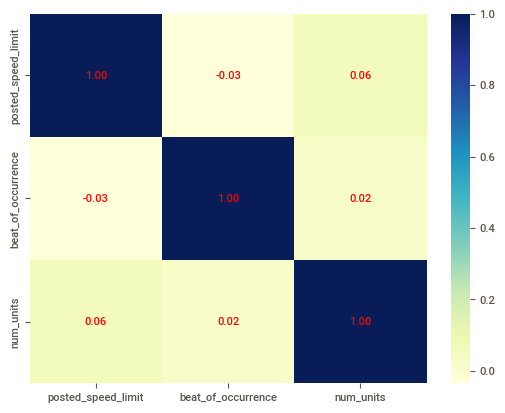

In [62]:
heatmap = sn.heatmap(numerical_train.corr(), cmap="YlGnBu", annot=True, fmt=".2f", annot_kws={"size": 8, "color": 'red'})

### Histograms of features wrt target variable and Plot of the numerical distribution

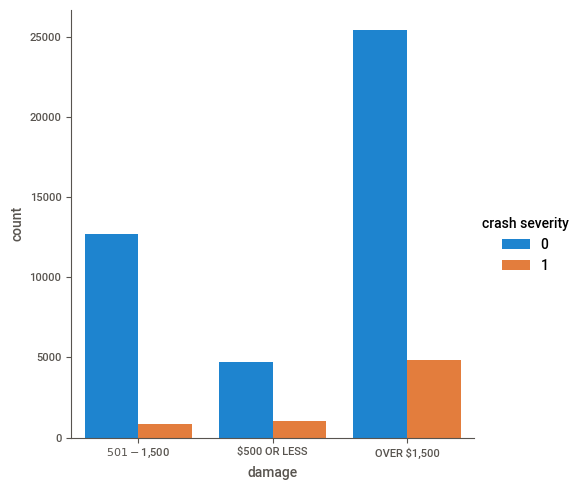

In [63]:
sn.catplot( x='damage', kind='count', hue='crash severity', data=df_dropped)

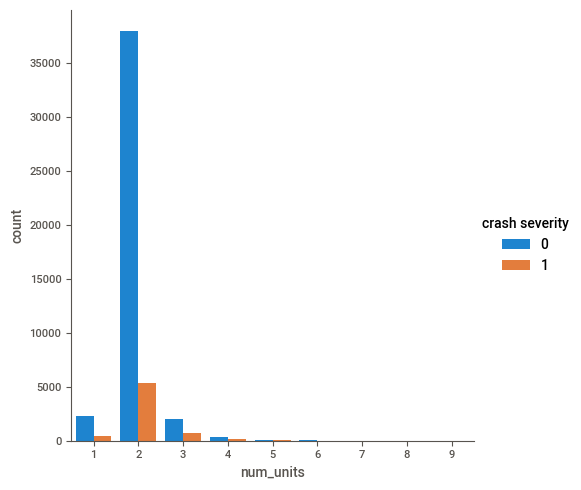

In [64]:
sn.catplot( x='num_units', kind='count', hue='crash severity', data=df_dropped)

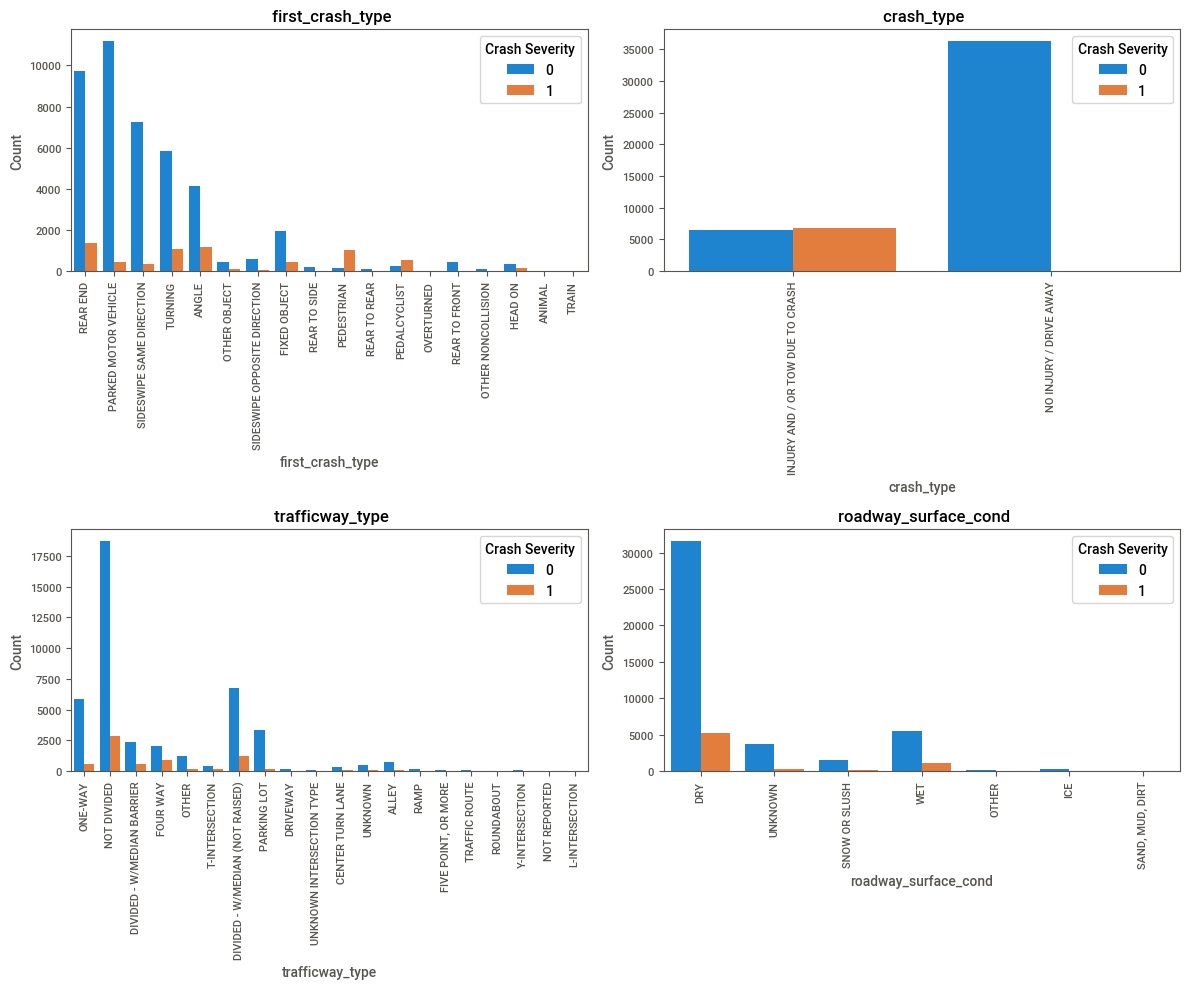

In [65]:

x_variables = ['first_crash_type','crash_type','trafficway_type','roadway_surface_cond', 'device_condition']

# Creare il subplot
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()

# Iterare sui subplot e tracciare gli istogrammi
for i, ax in enumerate(axes):
    if i < len(x_variables):
        sn.countplot(x=x_variables[i], hue='crash severity', data=df_dropped, ax=ax)
        ax.set_title(' {}'.format(x_variables[i]))
        ax.set_ylabel('Count')
        ax.legend(title='Crash Severity', loc='upper right')  # Aggiungi legenda
        
        # Ruota le etichette sull'asse x per renderle più leggibili
        ax.tick_params(axis='x', rotation=90)
    else:
        # Nascondi subplot non utilizzati
        ax.axis('off')

plt.tight_layout()
plt.show()


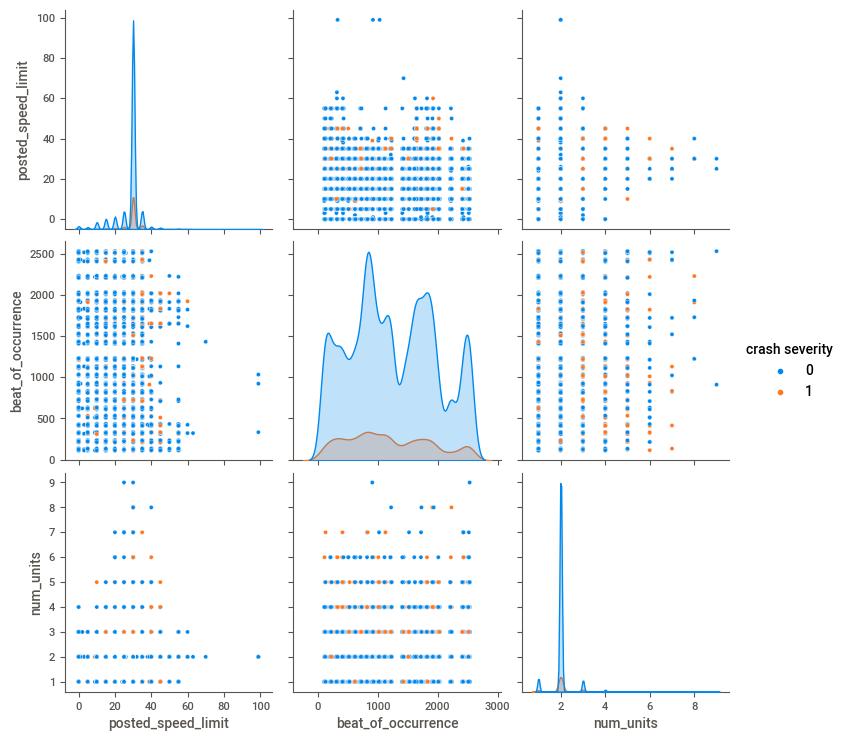

In [66]:
import warnings
warnings.filterwarnings('ignore')
sn.pairplot(df_dropped, hue='crash severity')

<br>

## ENCODING : 

Many machine learning algorithms work exclusively with numeric data. That is why we need to encode categorical features into a representation compatible with the models.


**One Hot Encoding** <br>
This method creates binary columns for each category in the variable. Each column represents one category, and it has a value of 1 if the observation belongs to that category and 0 otherwise.
X_train_cat is the dataframe with only the categorical features One Hot Encoded


In [16]:
categorical_columns= ['traffic_control_device', 'device_condition', 'weather_condition','lighting_condition', 
                      'first_crash_type', 'trafficway_type','roadway_surface_cond', 'crash_type']

X_train_cat = pd.get_dummies(non_ordinal_train[categorical_columns], drop_first=True, dtype=int)
X_test_cat =  pd.get_dummies(non_ordinal_test[categorical_columns], drop_first=True, dtype=int)

#check, same number of rows
print(X_train_cat.shape, X_test_cat.shape) #error

(39652, 84) (9913, 81)


In [17]:
# Trova le colonne che sono presenti in X_train_cat ma non in X_test_cat
missing_columns = set(X_train_cat.columns) - set(X_test_cat.columns)
print("Colonne mancanti in X_test_cat:", missing_columns)

# Trova le colonne che sono presenti in X_test_cat ma non in X_train_cat
extra_columns = set(X_test_cat.columns) - set(X_train_cat.columns)
print("Colonne aggiuntive in X_test_cat:", extra_columns)

Colonne mancanti in X_test_cat: {'weather_condition_BLOWING SNOW', 'traffic_control_device_NO PASSING', 'first_crash_type_TRAIN'}
Colonne aggiuntive in X_test_cat: set()


In [18]:
col_to_drop = ['traffic_control_device_NO PASSING',
 'weather_condition_BLOWING SNOW',
 'first_crash_type_TRAIN']

X_train_cat = X_train_cat.drop(col_to_drop, axis=1)


In [19]:
X_train_cat.shape, X_test_cat.shape 

((39652, 81), (9913, 81))

In [20]:
X_train_cat.head()

traffic_control_device_DELINEATORS  \
43702                                   0   
77834                                   0   
69035                                   0   
11723                                   0   
60867                                   0   

       traffic_control_device_FLASHING CONTROL SIGNAL  \
43702                                               0   
77834                                               0   
69035                                               0   
11723                                               0   
60867                                               0   

       traffic_control_device_LANE USE MARKING  \
43702                                        0   
77834                                        0   
69035                                        0   
11723                                        0   
60867                                        0   

       traffic_control_device_NO CONTROLS  traffic_control_device_OTHER  \
43702                                   1                             0   
77834                                   1                             0   
69035                                   1                             0   
11723                                   1                             0   
60867                                   1                             0   

       traffic_control_device_OTHER RAILROAD CROSSING  \
43702                                               0   
77834                                               0   
69035                                               0   
11723                                               0   
60867                                               0   

       traffic_control_device_OTHER REG. SIGN  \
43702                                       0   
77834                                       0   
69035                                       0   
11723                                       0   
60867                                       0   

       traffic_control_device_OTHER WARNING SIGN  \
43702                                          0   
77834                                          0   
69035                                          0   
11723                                          0   
60867                                          0   

       traffic_control_device_PEDESTRIAN CROSSING SIGN  \
43702                                                0   
77834                                                0   
69035                                                0   
11723                                                0   
60867                                                0   

       traffic_control_device_POLICE/FLAGMAN  ...  trafficway_type_UNKNOWN  \
43702                                      0  ...                        0   
77834                                      0  ...                        0   
69035                                      0  ...                        0   
11723                                      0  ...                        0   
60867                                      0  ...                        0   

       trafficway_type_UNKNOWN INTERSECTION TYPE  \
43702                                          0   
77834                                          0   
69035                                          0   
11723                                          0   
60867                                          0   

       trafficway_type_Y-INTERSECTION  roadway_surface_cond_ICE  \
43702                               0                         0   
77834                               0                         0   
69035                               0                         0   
11723                               0                         0   
60867                               0                         0   

       roadway_surface_cond_OTHER  roadway_surface_cond_SAND, MUD, DIRT  \
43702                           0                                     0   
77834 

**Label Encoding** <br>
This method assigns a unique integer to each category, similar to ordinal encoding. However, label encoding does not consider the order or rank of the categories. It simply assigns integers in alphabetical order or based on the order in which the categories appear in the dataset.

In [21]:
from sklearn.preprocessing import LabelEncoder
COL = 'damage'
# We created a copy of X_train and X_test, just to show how to work with LabelEncoder, but we do not 
# want to modify the DataFrames.

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

label_enc = LabelEncoder()
label_enc.fit(X_train_copy[COL])

#fit_transfor train
X_train_copy.loc[:, COL] = label_enc.fit_transform(X_train_copy[COL])
#transform set
X_test_copy.loc[:, COL] = label_enc.transform(X_test_copy[COL])



In [22]:
#check that the label col is actually encoded
X_train[COL].unique(), X_train_copy[COL].unique()

(array(['$501 - $1,500', 'OVER $1,500', '$500 OR LESS'], dtype=object),
 array([1, 2, 0]))

At this point **X_train_copy** contains `damage encoded`, the `numerical features` and the **categorical features NOT encoded**. 

What is left is to concatenate it with **X_train_ohe** to have also the `categorical features encoded`.

The same hold true for X_test_copy.

In [23]:
X_train_copy.head(2)

posted_speed_limit traffic_control_device device_condition  \
43702                30.0            NO CONTROLS      NO CONTROLS   
77834                30.0            NO CONTROLS      NO CONTROLS   

      weather_condition      lighting_condition      first_crash_type  \
43702              SNOW  DARKNESS, LIGHTED ROAD  PARKED MOTOR VEHICLE   
77834           UNKNOWN                 UNKNOWN  PARKED MOTOR VEHICLE   

      trafficway_type roadway_surface_cond              crash_type  damage  \
43702         ONE-WAY        SNOW OR SLUSH  NO INJURY / DRIVE AWAY       1   
77834     PARKING LOT              UNKNOWN  NO INJURY / DRIVE AWAY       2   

       beat_of_occurrence  num_units  
43702              2524.0          2  
77834              2222.0          2

Thus let's create the final encoded dataset, both for Train and Test set.

In [24]:
X_train_ohe = pd.concat([X_train_copy, X_train_cat], axis=1).drop(categorical_columns, axis=1)
X_test_ohe = pd.concat([X_test_copy, X_test_cat], axis=1).drop(categorical_columns, axis=1)


print(X_train_ohe.shape, X_test_ohe.shape)
      
X_train_ohe.head()


(39652, 85) (9913, 85)


posted_speed_limit  damage  beat_of_occurrence  num_units  \
43702                30.0       1              2524.0          2   
77834                30.0       2              2222.0          2   
69035                30.0       2              1222.0          2   
11723                30.0       2              1413.0          2   
60867                35.0       2              1831.0          2   

       traffic_control_device_DELINEATORS  \
43702                                   0   
77834                                   0   
69035                                   0   
11723                                   0   
60867                                   0   

       traffic_control_device_FLASHING CONTROL SIGNAL  \
43702                                               0   
77834                                               0   
69035                                               0   
11723                                               0   
60867                                               0   

       traffic_control_device_LANE USE MARKING  \
43702                                        0   
77834                                        0   
69035                                        0   
11723                                        0   
60867                                        0   

       traffic_control_device_NO CONTROLS  traffic_control_device_OTHER  \
43702                                   1                             0   
77834                                   1                             0   
69035                                   1                             0   
11723                                   1                             0   
60867                                   1                             0   

       traffic_control_device_OTHER RAILROAD CROSSING  ...  \
43702                                               0  ...   
77834                                               0  ...   
69035                                               0  ...   
11723                                               0  ...   
60867                                               0  ...   

       trafficway_type_UNKNOWN  trafficway_type_UNKNOWN INTERSECTION TYPE  \
43702                        0                                          0   
77834                        0                                          0   
69035                        0                                          0   
11723                        0                                          0   
60867                        0                                          0   

       trafficway_type_Y-INTERSECTION  roadway_surface_cond_ICE  \
43702                               0                         0   
77834                               0                         0   
69035                               0                         0   
11723                               0                         0   
60867                               0                         0   

       roadway_surface_cond_OTHER  roadway_surface_cond_SAND, MUD, DIRT  \
43702                           0                                     0   
77834                           0                                     0   
69035                           0                                     0   
11723                           0                                     0   
60867                           0                                     0   

       roadway_surface_cond_SNOW OR SLUSH  roadway_surface_cond_UNKNOWN  \
43702                                   1                             0   
77834                                   0                             1   
69035                                   0                             1   
11723                                   0                             0   
60867                                   0                             0   

       roadway_surface_cond_WET  crash_type_NO INJURY / DRIVE AWAY  
43702                 

### MODEL SELECTION

I pinned down five classification models with different characteristics and increasing level of complexity.

   * Logistic Regression model

- Bagging method
    * Random forest model
    
- Boosting method
    * Adaboost model
    * Gradient Boosting model
    * XGBoost Classifier model

*I intentionally ruled out a simple tree (Cart Classifier) owing to theory and empirical researches outline that almost always Ensemble methods performs better that a simple tree


<br>

### LOGISTIC REGRESSION

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_ohe_log = scaler.fit_transform(X_train_ohe)

In [77]:
#recalling the proportion of the target variables
y_train.value_counts(normalize = True)

0    0.862857
1    0.137143
Name: crash severity, dtype: float64

Since we are dealing with manifolds features, to further prevent overfittig and multicollinearity we add the ridge regularization 'l2'.
- C = 0.01 is the inverse regularization parameter obtained via GridSearch

In [78]:
#fitting the model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l2', solver = 'newton-cg', C= 0.01 )
model.fit(X_train_ohe_log, y_train)


LogisticRegression(C=0.01, solver='newton-cg')

When the predictor are scaled the **𝛽_i** can be used to understand the importance of the **𝑥_𝑖** over **𝑦**, the ones with the highest absolute value are the most important.
- A positive **𝛽_𝑖** means that for positive values of 𝑥𝑖 the 𝛽𝑥 increase , hence 𝒑(𝒙)  goes toward 1
- Negative **𝛽_𝑖** means that for positive values of 𝑥𝑖 the 𝛽𝑥 decrease, hence 𝒑(𝒙) decreases toward 0

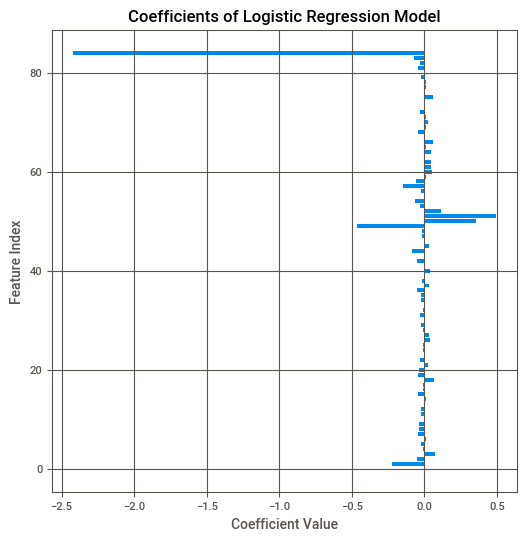

In [79]:
coefficients = model.coef_[0]  # Assumendo che model sia il tuo modello di regressione logistica

# Plot dei coefficienti
plt.figure(figsize=(6,6))
plt.barh(range(len(coefficients)), coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Index')
plt.title('Coefficients of Logistic Regression Model')
plt.grid(True)
plt.show()

In [80]:
#predict the probability to be in the class Crash severity high = 1
X_test_ohe_log = scaler.transform(X_test_ohe)

probability_logistic = model.predict_proba(X_train_ohe_log)[:,1]
probability_logistic

array([6.75090626e-04, 8.88759973e-04, 1.88581121e-03, ...,
       5.72594090e-01, 9.78685522e-01, 4.73263071e-03])

Looking at the graph, we can notice that in the centre the two distributions
overlap each other. 
Indeed, it is not an excellent result since the low intensity crash proportion amount to 86%. 

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets, and some other measures like precision, recall and f1score are more appropiate.

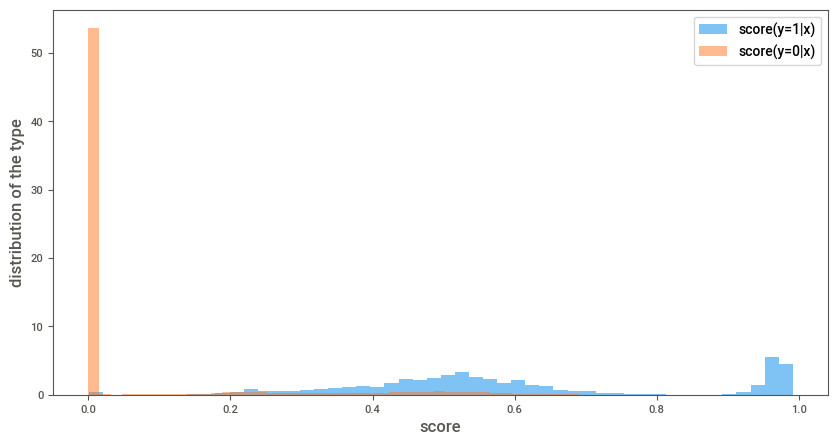

In [81]:
#Plotting the prediction
fig, ax = plt.subplots(1,1, figsize = (10,5))

high_distr = probability_logistic[y_train == 1]
low_distr = probability_logistic[y_train== 0]

ax.hist(high_distr,  label='score(y=1|x)', density=True, alpha=0.5, bins=50)
ax.hist(low_distr,  label='score(y=0|x)', density=True, alpha=0.5, bins=50)

ax.set_xlabel('score', fontsize=12)
ax.set_ylabel('distribution of the type',fontsize=12)
ax.legend()

plt.show()

**Choosing the right threshold pt1**

Notwithstanding, the prediction depends on the threshold that is automatically setted at 0.5 and this is not a suitable one since the data set is quite unbalanced.

I recall that all the metrics discussed above depend on the choice of the threshold 𝑡 and thus picking a proper threshold is paramount!

Therefore, a much better way to pick a threshold is to employ confusion matrix, this time on the **Train set**. Usually cm are deployed on the test set, but in this case we are seeking for the best threshold in the training set!

 We'll carry out confusion matrixes for each treshold and then based on f1score we set the best one.

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).

Confusion matrix for threshold = 0.05


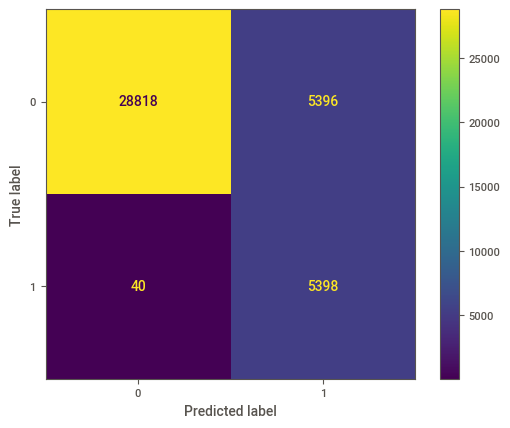

Confusion matrix for threshold = 0.1


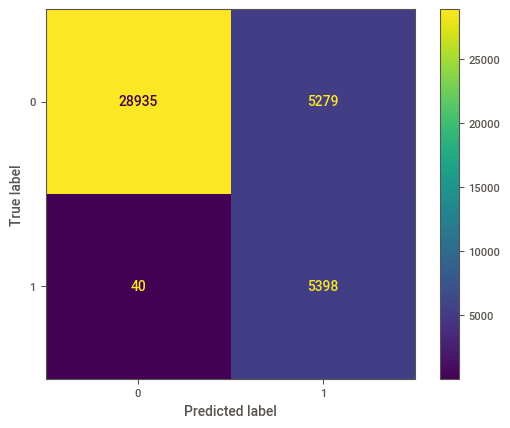

Confusion matrix for threshold = 0.15000000000000002


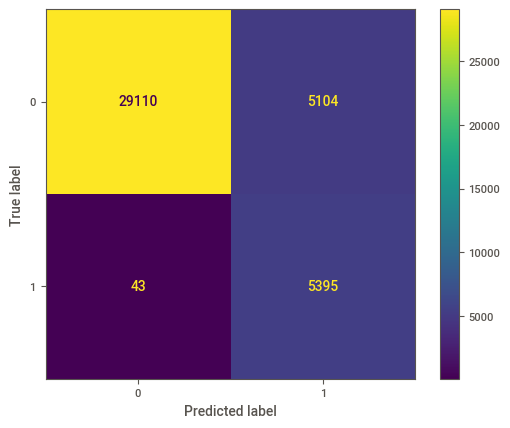

Confusion matrix for threshold = 0.2


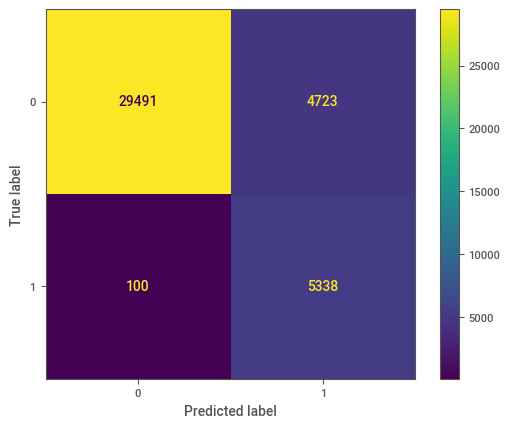

Confusion matrix for threshold = 0.25


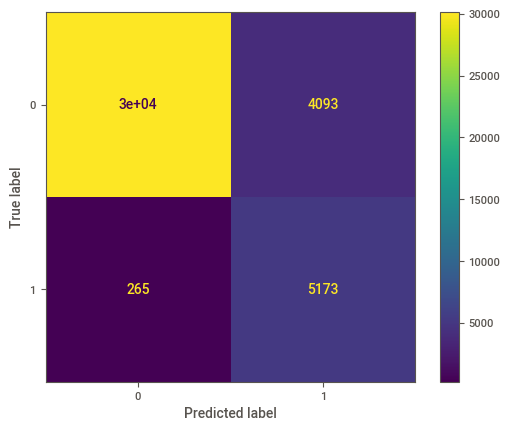

Confusion matrix for threshold = 0.3


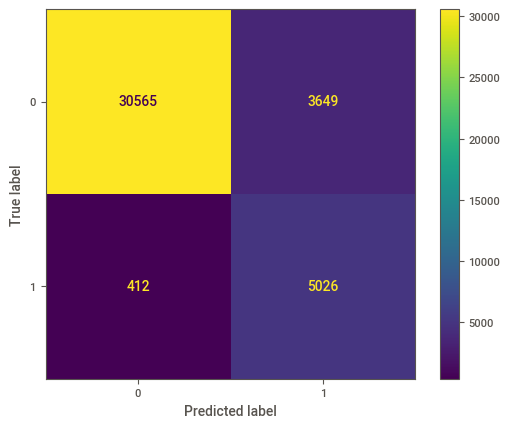

Confusion matrix for threshold = 0.35000000000000003


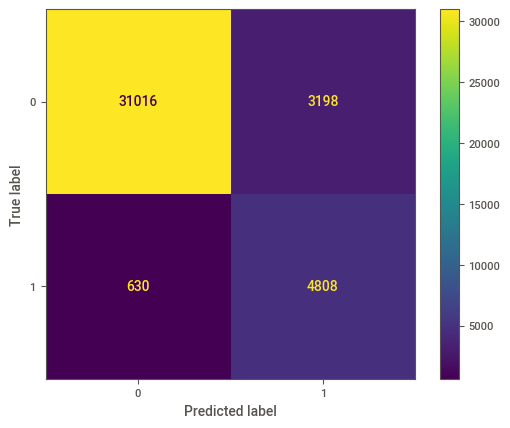

Confusion matrix for threshold = 0.4


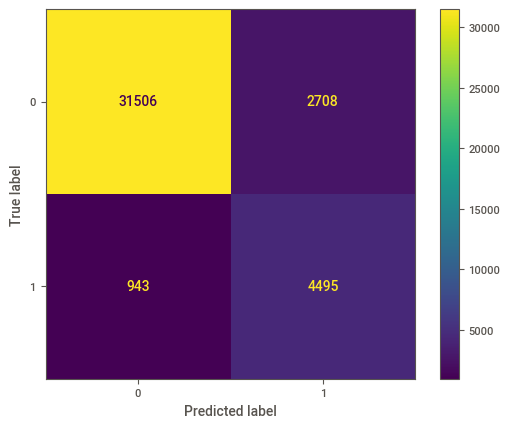

Confusion matrix for threshold = 0.45


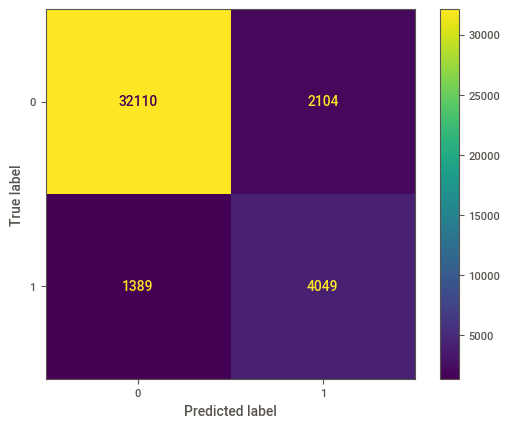

Confusion matrix for threshold = 0.5


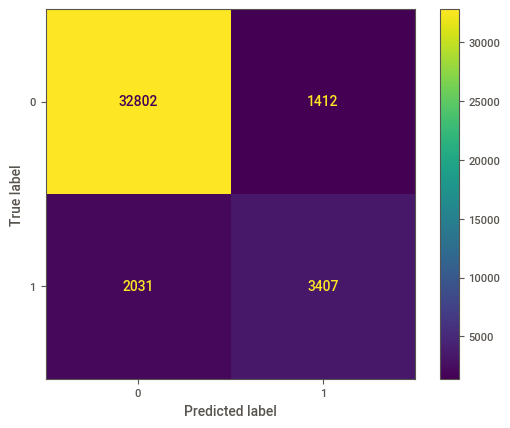

Confusion matrix for threshold = 0.55


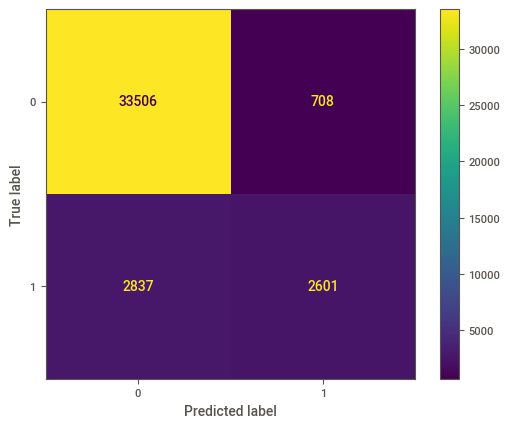

Confusion matrix for threshold = 0.6000000000000001


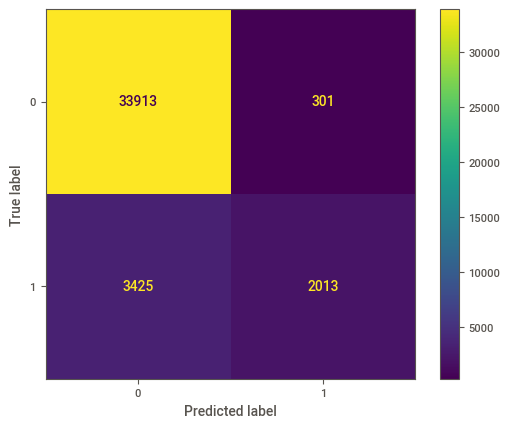

Confusion matrix for threshold = 0.6500000000000001


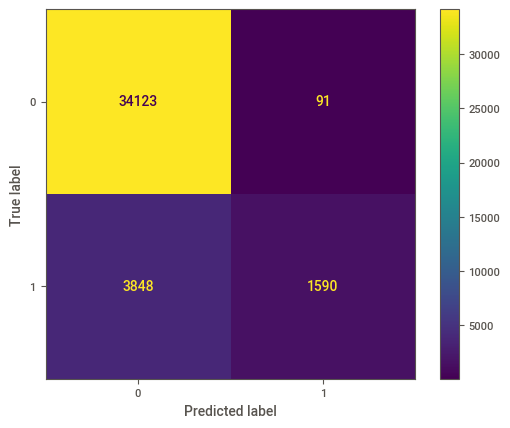

Confusion matrix for threshold = 0.7000000000000001


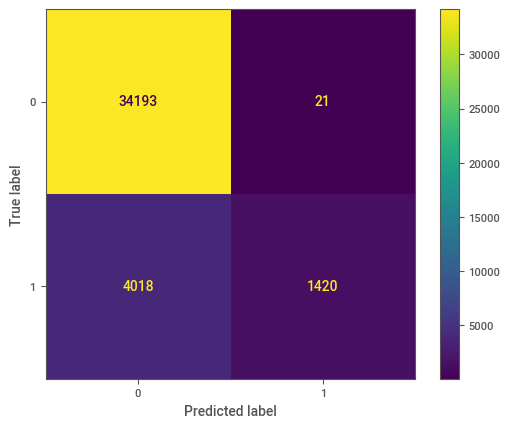

Confusion matrix for threshold = 0.7500000000000001


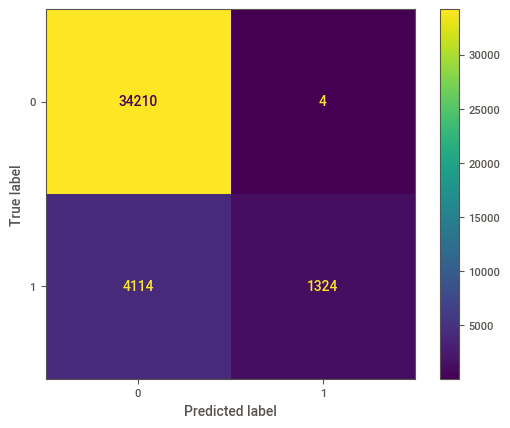

Confusion matrix for threshold = 0.8


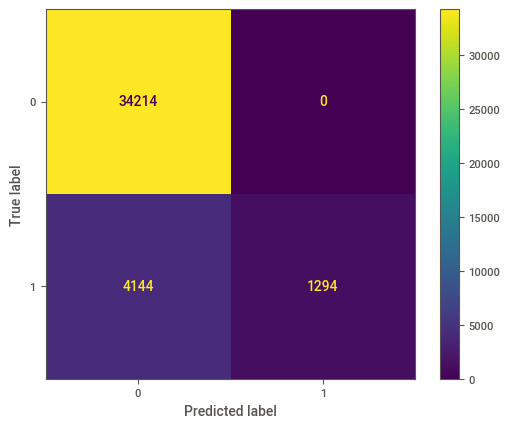

Confusion matrix for threshold = 0.8500000000000001


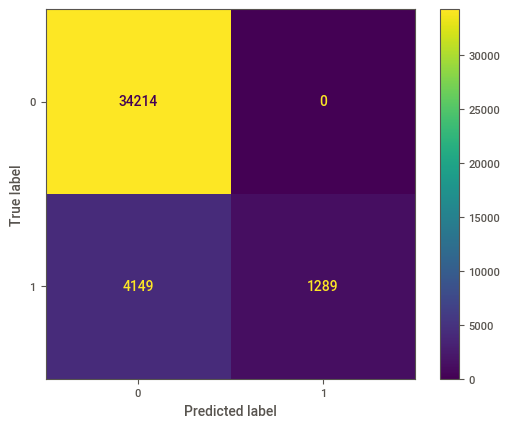

Confusion matrix for threshold = 0.9000000000000001


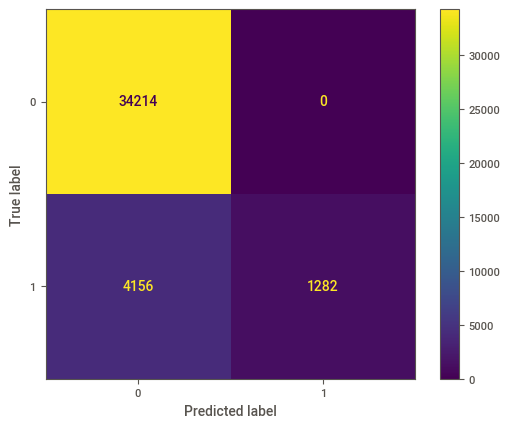

Confusion matrix for threshold = 0.9500000000000001


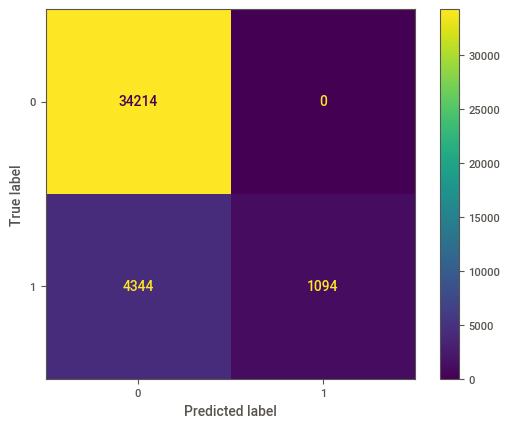

0         1         2         3         4         5   \
THRESHOLD      0.05       0.1      0.15       0.2      0.25       0.3   
accuracy   0.862907  0.865858  0.870196  0.878367  0.890094  0.897584   
recall     0.992644  0.992644  0.992093  0.981611  0.951269  0.924237   
tnr        0.992644  0.992644  0.992093  0.981611  0.951269  0.924237   
fpr        0.007356  0.007356  0.007907  0.018389  0.048731  0.075763   
precision  0.500093  0.505573  0.513858  0.530564  0.558278  0.579366   
f1_score   0.665106  0.669935  0.677041  0.688819  0.703618  0.712251   

                 6         7         8         9         10        11  \
THRESHOLD      0.35       0.4      0.45       0.5      0.55       0.6   
accuracy    0.90346  0.907924  0.911909   0.91317  0.910597  0.906032   
recall     0.884149  0.826591  0.744575  0.626517  0.478301  0.370173   
tnr        0.884149  0.826591  0.744575  0.626517  0.478301  0.370173   
fpr        0.115851  0.173409  0.255425  0.373483  0.521699  0.629827   
precision   0.60055  0.624046  0.658053  0.706993  0.786038  0.869922   
f1_score   0.715263  0.711178  0.698646  0.664327  0.594718   0.51935   

                 12        13        14        15        16        17  \
THRESHOLD      0.65       0.7      0.75       0.8      0.85       0.9   
accuracy   0.900661  0.898139  0.896146  0.895491  0.895365  0.895188   
recall     0.292387  0.261125  0.243472  0.237955  0.237036  0.235748   
tnr        0.292387  0.261125  0.243472  0.237955  0.237036  0.235748   
fpr        0.707613  0.738875  0.756528  0.762045  0.762964  0.764252   
precision  0.945866  0.985427  0.996988       1.0       1.0       1.0   
f1_score   0.446692  0.412851  0.391369  0.384433  0.383232  0.381548   

                 18  
THRESHOLD      0.95  
accuracy   0.890447  
recall     0.201177  
tnr        0.201177  
fpr        0.798823  
precision       1.0  
f1_score   0.334966

In [82]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

THRESHOLD = np.arange(0.05,1,0.05)
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"]) 
# threshold column
results['THRESHOLD'] = THRESHOLD   
j = 0
# iterate over each threshold 
for i in THRESHOLD:
    preds = np.where(probability_logistic > i, 1, 0)
    print('Confusion matrix for threshold =', i)
    
    cm = confusion_matrix(y_train, preds, labels=model.classes_)
    
    
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    TP = cm[0][0]   # True Positives
    FN = cm[0][1]   # False Positives
    FP = cm[1][0]   # True Negatives
    TN = cm[1][1]   # False Negatives
    
    results.iloc[j, 1] = accuracy_score(y_train, preds) 
    results.iloc[j, 2] = recall_score(y_train, preds)
    results.iloc[j, 3] = TN / (FP + TN)  # True negative rate
    results.iloc[j, 4] = FP / (FP + TN)  # False positive rate
    results.iloc[j, 5] = precision_score(y_train, preds)
    results.iloc[j, 6] = f1_score(y_train, preds)
    
    j += 1

results.T


<br>

**Choosing the right treshold pt2** <br>

We know that conventionally the class 0 = low crash is selceted as Positive and 1 = high crash is Negative.

Therefore, I want to keep as minimun as possible **False Negative**, in this case the **"False High Severity"** (Predicted 0, True label 1) have a crucial role and so I prefer **Recall** than precision.  

The behaviour of **Recall** is decreasing as we in increase the threshold since it raises up the number of **False Negative**, roughly speaking the cell below the yellow one.

In conclusion, base also on the above graph of the distribution of the prediction, I will choose 0.20 as threshold.

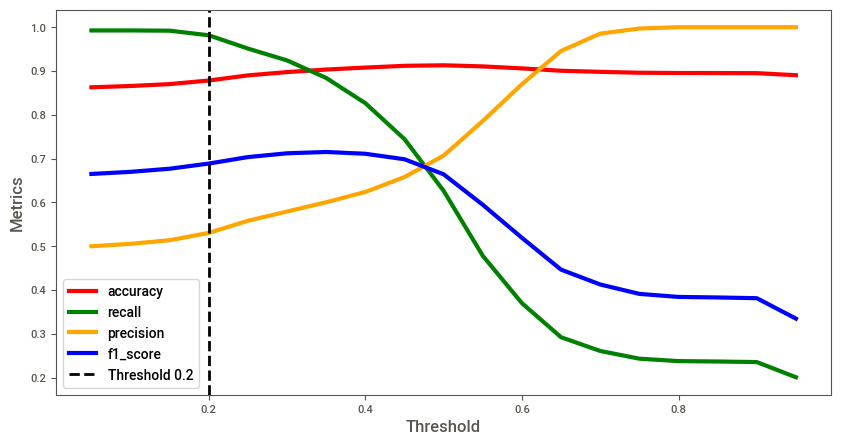

In [83]:

fig, ax = plt.subplots(1,1,figsize=(10,5))
thr = results["THRESHOLD"].values
acc = results["accuracy"].values
recall = results["recall"].values
precision = results["precision"].values
f1_score = results["f1_score"].values
ax.plot(thr, acc, c="red", label="accuracy", linewidth=3)
ax.plot(thr, recall, c="green", label="recall", linewidth=3)
ax.plot(thr, precision, c="orange", label="precision", linewidth=3)
ax.plot(thr, f1_score, c="blue", label="f1_score", linewidth=3)
ax.axvline(x=0.2, color='black', linestyle='--', linewidth=2, label='Threshold 0.2')
ax.legend()
ax.set_xlabel("Threshold", fontsize=12)
ax.set_ylabel("Metrics", fontsize=12)

plt.show()


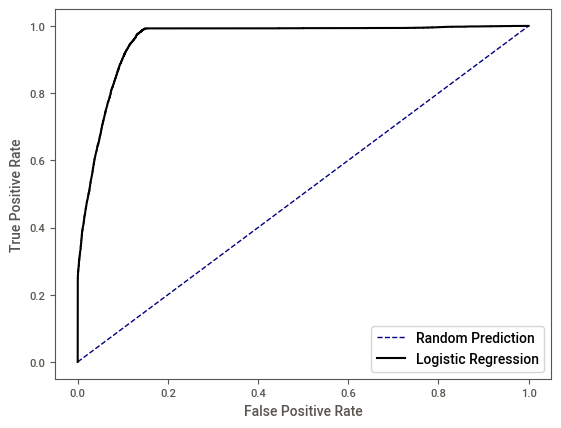

AUC Score :  0.9582709040106325


In [84]:
lr_auc=roc_auc_score(y_train, probability_logistic)

lr_fpr,lr_tpr, thresholds =roc_curve(y_train, probability_logistic) #compute the Roc curv


plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
plt.plot(lr_fpr,lr_tpr , color="black" , label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)


Addictionally, also the Precision-Recall graphs seems to suggest that 0.2 is a reasonable choice.

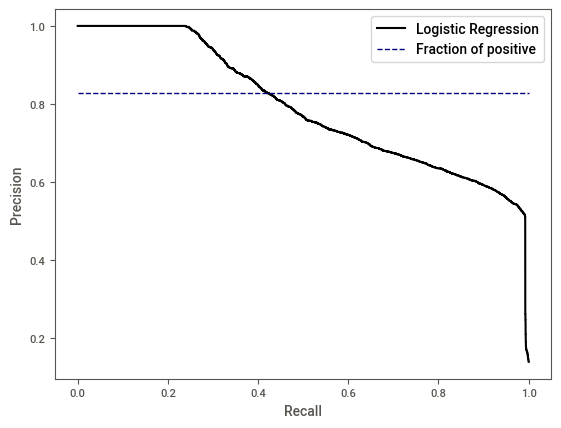

In [85]:
from sklearn.metrics import precision_recall_curve
precision , recall , thresholds = precision_recall_curve(y_train, probability_logistic)

plt.plot(recall, precision , color="black" , label='Logistic Regression')
plt.plot([0,1], [0.82760207, 0.82760207],  color="navy", lw=1, linestyle="--", label='Fraction of positive')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Hyperparameters Tuning and Cross Validation

We split the initial dataset into training, validation, and test datasets. The training dataset is used for model fitting, the validation dataset is used for hyperparameter tuning, and the test dataset is kept separate only for final evaluation.

  - For the hyperparameter Tuning we used Grid Search that systematically search through a specified parameters grid and select the optimal hp that maximize model performance on the validation dataset.
  - Throughout this notebook I established a range for the hyperparameter in this way :
             - Fitting the model withouth gridsearch to have an idea of the hyperparameters      
             - Looking at the dimension of my dataset and the computational capacity of my device
             - Sklearn documentation
             - Notebook of the professor and some notebook of Kaggle competition 

<br>

**Stratified K-Fold Cross-Validation**<br>
- As cross validation, I opted for Stratified K-Fold Cross-Validation where the dataset is divided into k folds while preserving the percentage of samples for each class. This ensures that each fold is representative of the overall class distribution in the dataset. I reckon this it's compelling in our situation where we have a quite unbalanced dataset. his leads to more reliable performance estimates and reduces the risk of overfitting.


- Why does CV run on the training Set?
   - It's remarkable to note that cross-validation is performed **only** on the training dataset, not on the test dataset!! 
     This prevent **data leakage**, where information from the test dataset influences the model training process, leading to optimistic performance estimates. By strictly separating the training and test datasets, we ensure an unbiased evaluation of the model. We cannot squint into the test set before your model finished!

- To sum up, hyperparameter tuning with grid search, combined with stratified k-fold cross-validation, allows us to select the best model hyperparameters while ensuring unbiased model evaluation and preventing data leakage. This approach leads to more robust and generalizable machine learning models.

<br>

## Random Forest 

`Random forest` is a Bagging algorithm, it stems from bootstrap aggregation. Indeed, It uses bootstrap with replacement to pick roughly 2/3 of `X_train_ohe` rows. 
Then it builds multiple decision trees **separately**, but at each split it samples **randomly** a bunch of features, thereby trees are **decorrelated**, and then combines their predictions to improve accuracy. 
The final prediction consider the majority voting class in classicication problem as this one. 
<br>


- When training a Random Forest model, there are several hyperparameters that can be tuned by the means of GridSearch within the Cross validation, e.g. :

`n_estimators`: The number of trees in the forest. A higher value can improve the model's performance, but also increases training time. According con the dimension of data, values between 50 and 500 are commonly used.

`max_features`: The number of features to consider when looking for the best split at each node in the bootstrapped sub-dataset.

`max_depth`: The maximum depth of each tree in the forest. A higher value can lead to greater model complexity and the risk of overfitting.

`min_samples_split`: The minimum number of samples required to split an internal node. A higher value can lead to stronger regularization.

`min_samples_leaf`: The minimum number of observations to be at a leaf node. A higher value can act as regularization factor.

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

# hyperparameters
params = {
    'n_estimators': [5, 10, 20, 100, 150], 
    'max_features': ['sqrt'],
    'max_depth': [3, 4, 5, 6],                           
}  

# Stratified Kfold-validation
skf = StratifiedKFold(5, shuffle=True, random_state=42)

# GridSearchCV to pin down the best hyperparameters
gs = GridSearchCV(
    rf_model,
    params,
    cv=skf,
    scoring="roc_auc",
    n_jobs= 4,
    refit=True
)   

# Fitting
gs.fit(X_train_ohe, y_train)


In [ ]:
#result contains all the combinations of hyper_parameters
result = pd.DataFrame(gs.cv_results_)
result.head(2)

In [ ]:
#visualizing top fifth model
#ascending = True allows us to have rank_test_score in the first position
best_rf_params = result.sort_values("rank_test_score", ascending= True).iloc[0:5]
best_rf_params

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19       2.234385      0.170850         0.100659        0.016256   
18       1.765136      0.051024         0.092342        0.007081   
13       1.420624      0.059103         0.079179        0.007926   
14       1.921097      0.067540         0.092175        0.012003   
8        1.190651      0.038358         0.070816        0.009693   

   param_max_depth param_max_features param_n_estimators  \
19               6               sqrt                150   
18               6               sqrt                100   
13               5               sqrt                100   
14               5               sqrt                150   
8                4               sqrt                100   

                                               params  split0_test_score  \
19  {'max_depth': 6, 'max_features': 'sqrt', 'n_es...           0.958106   
18  {'max_depth': 6, 'max_features': 'sqrt', 'n_es...           0.958163   
13  {'max_depth': 5, 'max_features': 'sqrt', 'n_es...           0.958057   
14  {'max_depth': 5, 'max_features': 'sqrt', 'n_es...           0.955750   
8   {'max_depth': 4, 'max_features': 'sqrt', 'n_es...           0.956838   

    split1_test_score  split2_test_score  split3_test_score  \
19           0.953258           0.953769           0.949582   
18           0.952142           0.955030           0.948415   
13           0.952428           0.955165           0.945544   
14           0.952032           0.954253           0.946713   
8            0.951497           0.951627           0.946237   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
19           0.956300         0.954203        0.002901                1  
18           0.951985         0.953147        0.003270                2  
13           0.952893         0.952817        0.004148                3  
14           0.954394         0.952628        0.003189                4  
8            0.954388         0.952117        0.003540                5

In [ ]:
best_rf_model= gs.best_estimator_
best_rf_model 


RandomForestClassifier(max_depth=6, n_estimators=150)

Accuracy: 0.8913547866438011
Average Accuracy with cross val in the test set, evaluate overfitting: 0.8897414094475087
STD Accuracy with cross val in the tes set, evaluate overfitting: 0.00513620674532151


Average Accuracy with cross val in the training set, evaluate overfitting: 0.8953898846657082
Average Accuracy with cross val in the training set, evaluate overfitting: 0.00214213085145618
Precision score: 0.9964912280701754
Recall score:    0.2088235294117647
F1 Score:0.3452887537993921

Average F1 Score with cross val in the test set, evaluate overfitting: 0.3403225572520254
Std F1 Score with cross val in the test set, evaluate overfitting: 0.041323561314086286
Average  F1score with cross val in the training ning set, evaluate overfitting: 0.3832095759464381
STD F1score with cross val in the training set, evaluate overfitting: 0.019568114673494112
Report:
               precision    recall  f1-score   support

           0   0.888243  0.999883  0.940762      8553
           1   0.996491  0.208824  0.345289      1360

    accuracy                       0.891355      9913
   macro avg   0.942367  0.604353  0.643026      9913
weighted avg   0.903094  0.891355  0.859067      9913
 



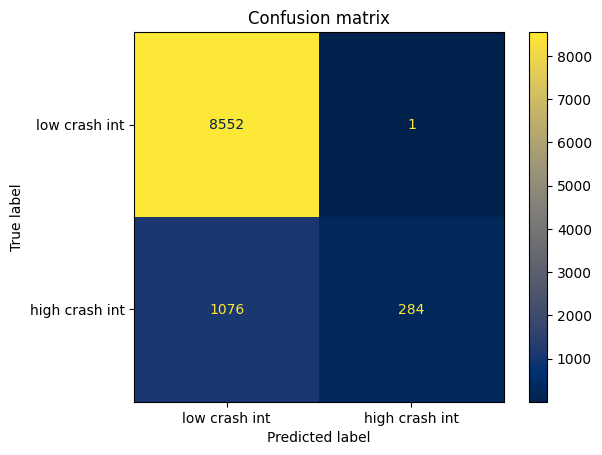



____________________________________________________________________________________________________




In [ ]:
from sklearn.metrics import f1_score
#make prediction, low = 0 and high =1
y_pred_rf = best_rf_model.predict(X_test_ohe)

#computing metrics to evaluate the model on the test set and then computing them on the train to asses overfitting

#Accuracy on TEST data -- model evaluation
print("Accuracy: {}".format(best_rf_model.score(X_test_ohe, y_test)))
print("Average Accuracy with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean())) 
print("STD Accuracy with cross val in the tes set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std())) 

#MEAN e STD of on Accuracy on TRAIN data -- check under/overfitting
print("Average Accuracy with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean()))
print("Average Accuracy with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std()))

print("Precision score: {}".format(precision_score(y_test, y_pred_rf)))
print("Recall score:    {}".format(recall_score(y_test, y_pred_rf)))

#F1 score on TEST data -- model evaluation
print("F1 Score:{}\n".format(f1_score(y_test, y_pred_rf)))
print("Average F1 Score with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean())) 
print("Std F1 Score with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))

#MEAN e STD of on Accuracy on test data -- check under/overfitting
print("Average  F1score with cross val in the training ning set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean()))
print("STD F1score with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_rf_model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))


print("Report:\n", classification_report(y_test, y_pred_rf,digits=6), "\n")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='cividis', display_labels=["low crash int","high crash int"])
plt.title("Confusion matrix")
plt.show()
print("\n")
print("_"*100)
print("\n")

In [ ]:
#predict_proba returns the probability, in this case we pick just the prob = 1 = high crash
prob_a_rf = best_rf_model.predict_proba(X_test_ohe)[:,1]

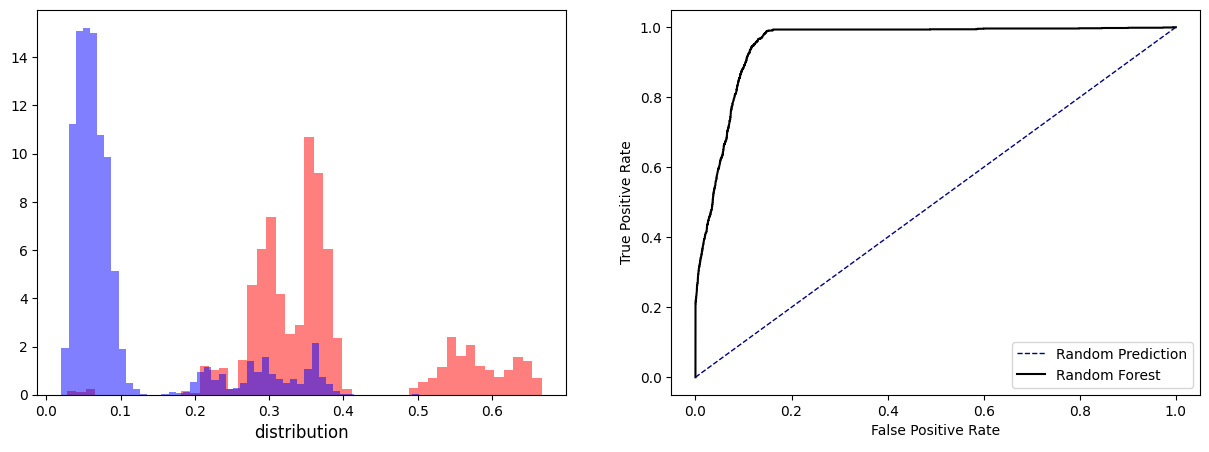

AUC Score :  0.9527352373780097


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
fig , ax = plt.subplots(1,2, figsize = (15,5))

uno_distr = prob_a_rf[y_test==1]
zero_distr = prob_a_rf[y_test==0]
ax[0].hist(uno_distr, color="red", density=True, alpha=0.5, bins=50)
ax[0].hist(zero_distr, color="blue", density=True, alpha=0.5, bins=50)
ax[0].set_xlabel("score", fontsize=12)
ax[0].set_xlabel("distribution", fontsize=12)

lr_auc=roc_auc_score(y_test, prob_a_rf)
lr_fpr,lr_tpr, thresholds =roc_curve(y_test,prob_a_rf)

ax[1].plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
ax[1].plot(lr_fpr,lr_tpr , color="black" , label='Random Forest')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)

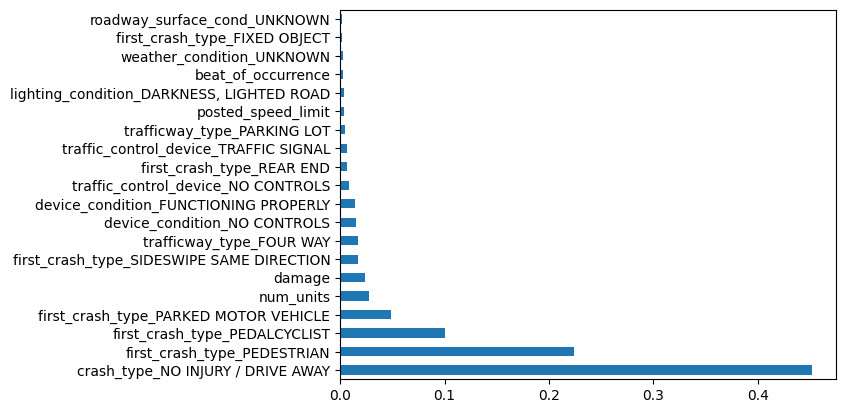

In [ ]:
feat_importances = pd.Series(best_rf_model.feature_importances_, index= X_train_ohe.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### AdaBoost 


`AdaBoost` is a boosting algorithm that sequentially trains a series of weak learners, either decision trees or stumps, on modified versions of the original dataset. The train set is sequentially adjusted in a way it focuses more on the instances that were previously misclassified, thereby giving them more weight in subsequent iterations. It means that the tree at step 2 will take the prediction errors of the step 1 and before to fit the tree will adjust the training set assigning more weight to the features incorrectly classified. The algorithm combines the predictions of these weak learners by giving more weight to the ones that perform better, effectively creating a one final strong learner that can better generalize to unseen data.

- When training a AdaBoost model, there are several hyperparameters that can be tuned by the means of GridSearch within the Cross validation, e.g. :

1. **n_estimators**: The number of weak learners (decision trees) to train sequentially. Increasing this parameter can lead to better performance but also increases computational complexity.

2. **learning_rate**: The contribution of each weak learner to the final prediction. A lower learning rate typically requires more weak learners to achieve the same level of performance but can lead to better generalization.

3. **base_estimator**: The base estimator used for training the weak learners. By default, AdaBoost uses decision trees, but other algorithms can be specified.

4. **algorithm**: The algorithm used for updating the weights of the training instances at each iteration. 

In [ ]:
%%time

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

ada_model = AdaBoostClassifier()

#hyparams
params = {
    'n_estimators': [5, 20, 50, 100, 150],                   # Nr. of sequential weak learnes
    'learning_rate': [0.005, 0.01, 0.1, 0.5, 0.7],           # learning rate
    'algorithm': ['SAMME.R']                                 # Alg for boosting
}

# Stratified Kfold-validation
skf = StratifiedKFold(5, shuffle=True, random_state=42)

#GridSearchCV
gs_ada = GridSearchCV(ada_model,
                            params, 
                            cv = skf, 
                            scoring='accuracy',
                            n_jobs= -1           #faster: -1 will use all available CPU cores for parallel processing
                            )

gs_ada.fit(X_train_ohe,y_train)


C:\Users\simob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


CPU times: total: 35 s
Wall time: 9min


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME.R'],
                         'learning_rate': [0.005, 0.01, 0.1, 0.5, 0.7],
                         'n_estimators': [5, 20, 50, 100, 150]},
             scoring='accuracy')

In [ ]:
results_ada = pd.DataFrame(gs_ada.cv_results_)

best_rf_params = results_ada.sort_values("rank_test_score")["params"][0:5]
best_rf_params

24    {'algorithm': 'SAMME.R', 'learning_rate': 0.7,...
23    {'algorithm': 'SAMME.R', 'learning_rate': 0.7,...
18    {'algorithm': 'SAMME.R', 'learning_rate': 0.5,...
19    {'algorithm': 'SAMME.R', 'learning_rate': 0.5,...
22    {'algorithm': 'SAMME.R', 'learning_rate': 0.7,...
Name: params, dtype: object

In [ ]:
# Ottenere i migliori parametri trovati
best_params = gs_ada.best_params_
print("Best parameters:", best_params)

Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.7, 'n_estimators': 150}


In [ ]:
# Ottenere il miglior modello trovato dalla grid search
best_ada_model = gs_ada.best_estimator_

# Valutare il modello sul set di test
accuracy = best_ada_model.score(X_test_ohe, y_test)
mean_accuracy = cross_val_score(model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean()
print("Accuracy on test set:", accuracy)
print("Mean Accuracy on test set via cross validation:", mean_accuracy)


Accuracy on test set: 0.9032583476243317
Mean Accuracy on test set via cross validation: 0.8869164894540018


Accuracy: 0.9032583476243317
Average Accuracy with cross val in the test set, evaluate overfitting: 0.9036623611494881
STD Accuracy with cross val in the tes set, evaluate overfitting: 0.005319375972224011
Average Accuracy with cross val in the training set, evaluate overfitting: 0.9047210468983508
Average Accuracy with cross val in the training set, evaluate overfitting: 0.0010410285396054778
Precision score: 0.691866028708134
Recall score:    0.5316176470588235
F1 Score:0.6012474012474013

Average F1 Score with cross val in the test set, evaluate overfitting: 0.6272097506200474
Std F1 Score with cross val in the test set, evaluate overfitting: 0.013468019495457551
Average  F1score with cross val in the training ning set, evaluate overfitting: 0.6123339900188356
STD F1score with cross val in the training set, evaluate overfitting: 0.005099463750174121
Report:
               precision    recall  f1-score   support

           0   0.928169  0.962352  0.944951      8553
           1   0.

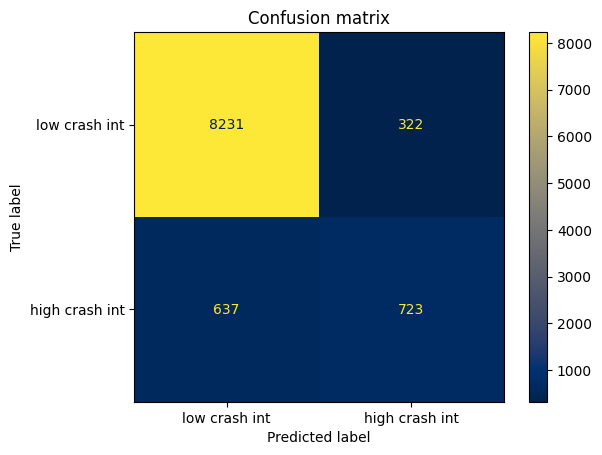



____________________________________________________________________________________________________




In [ ]:
from sklearn.metrics import f1_score
#make prediction, low = 0 and high =1
y_pred_ada = best_ada_model.predict(X_test_ohe)

#computing metrics to evaluate the model on the test set and then computing them on the train to asses overfitting

#Accuracy on TEST data -- model evaluation
print("Accuracy: {}".format(best_ada_model.score(X_test_ohe, y_test)))
print("Average Accuracy with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean())) 
print("STD Accuracy with cross val in the tes set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std())) 

#MEAN e STD of on Accuracy on TRAIN data -- check under/overfitting
print("Average Accuracy with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean()))
print("Average Accuracy with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std()))

print("Precision score: {}".format(precision_score(y_test, y_pred_ada)))
print("Recall score:    {}".format(recall_score(y_test, y_pred_ada)))

#F1 score on TEST data -- model evaluation
print("F1 Score:{}\n".format(f1_score(y_test, y_pred_ada)))
print("Average F1 Score with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean())) 
print("Std F1 Score with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))

#MEAN e STD of on Accuracy on test data -- check under/overfitting
print("Average  F1score with cross val in the training ning set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean()))
print("STD F1score with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_ada_model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))


print("Report:\n", classification_report(y_test, y_pred_ada,digits=6), "\n")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ada, cmap='cividis', display_labels=["low crash int","high crash int"])
plt.title("Confusion matrix")
plt.show()
print("\n")
print("_"*100)
print("\n")

In [ ]:
prob_a_ada = best_ada_model.predict_proba(X_test_ohe)[:,1]

Looking at the graph we can heed the model is rather thorough at dividing the two distribution wrt random forest. The two distributions tend to overlap just in a small region, this is good sign of sufficient model performance, confirmed by the metrics and the confusion matrix above.

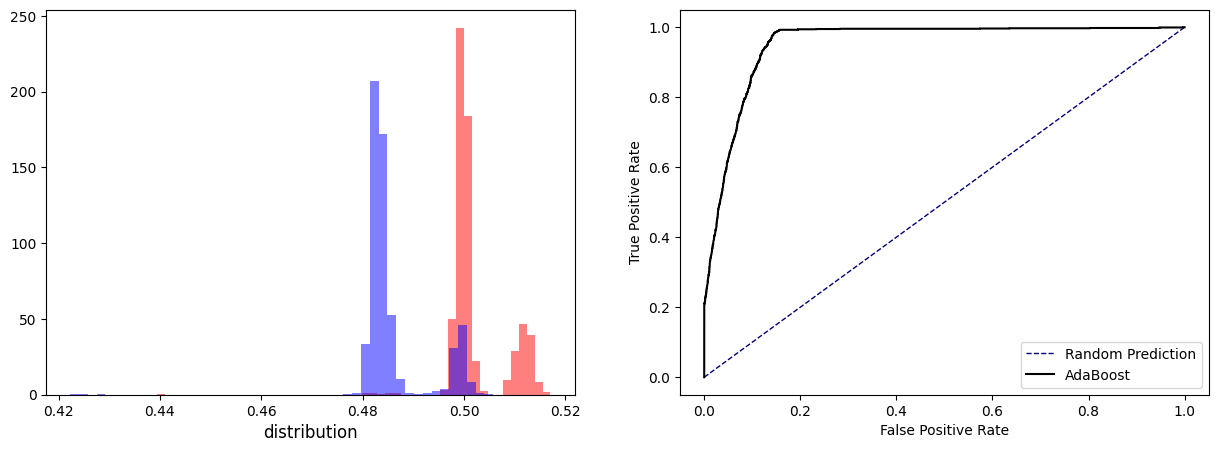

AUC Score :  0.9522753454240342


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
fig , ax = plt.subplots(1,2, figsize = (15,5))

high_distr = prob_a_ada[y_test==1]
low_distr = prob_a_ada[y_test==0]
ax[0].hist(high_distr, color="red", density=True, alpha=0.5, bins=50)
ax[0].hist(low_distr, color="blue", density=True, alpha=0.5, bins=50)
ax[0].set_xlabel("score", fontsize=12)
ax[0].set_xlabel("distribution", fontsize=12)

lr_auc=roc_auc_score(y_test, prob_a_ada)
lr_fpr,lr_tpr, thresholds =roc_curve(y_test, prob_a_ada)

ax[1].plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
ax[1].plot(lr_fpr,lr_tpr , color="black" , label='AdaBoost')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)

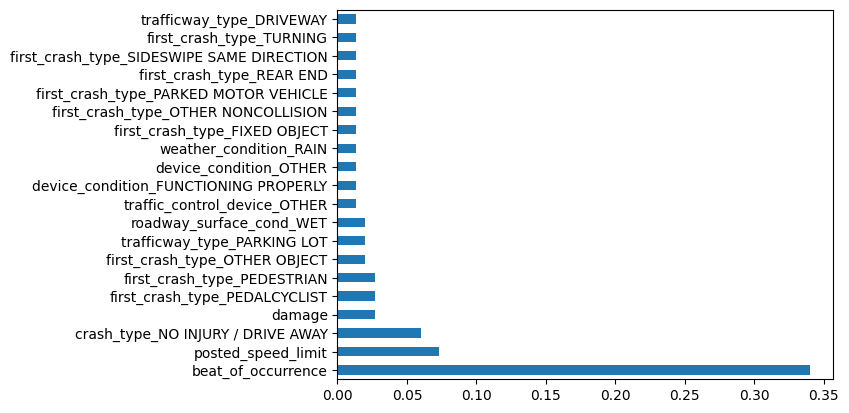

In [ ]:
feat_importances_ada = pd.Series(best_ada_model.feature_importances_, index= X_train_ohe.columns)
feat_importances_ada.nlargest(20).plot(kind='barh')
plt.show()

### GRADIENT BOOSTING

`Gradient Boosting` is another boosting algorithm that builds a series of decision trees sequentially. However, unlike AdaBoost, it fits each tree in the sequence to the **pseudo residual errors** made by the previous trees. 
This initial model is the most common class in the case of classification. Subsequently, additional models are created to correct the residual errors of the previous model. Generally in a classification problem **pseduo residual** are calculated converting the log(odds) of the target value by a sort of sigmoid. During the creation of each subsequent model, pseudo residuals, i.e., the difference between the observed value and the value predicted by the current model, are computed. Errors are weighted based on their importance and are used to train the next model. At the end of the process, the results of the individual models are combined to obtain the final prediction into a strong learner.

Gradient Boosting hinges upoon this main hyperparameters:

1. **n_estimators**: The number of decision trees in the ensemble. Increasing this parameter can lead to better performance but also increases computational complexity.

2. **learning_rate**: Shrinks the contribution of each tree in the ensemble. A lower learning rate typically requires more trees to achieve the same level of performance but can lead to better generalization.

3. **max_depth**: The maximum depth of each decision tree. A higher value can lead to greater model complexity and the risk of overfitting.

4. **min_samples_split**: The minimum number of samples required to split an internal node. A higher value can lead to stronger regularization.

5. **min_samples_leaf**: The minimum number of samples required to be at a leaf node. Similar to min_samples_split, it acts as a regularization factor.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Definisci il modello Gradient Boosting
gb_model = GradientBoostingClassifier()

# Definisci la griglia dei parametri da testare
params = {
    'learning_rate': [0.01, 0.005, 0.1, 0.3],
    'n_estimators': [5, 50, 100, 150],
    'max_depth': [3, 4, 5]
}

#GridSearch with Stratified K-fold cross validation
s_gboost = GridSearchCV(gb_model, params, cv = skf, scoring='roc_auc')

#fitting the model
s_gboost.fit(X_train_ohe, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.005, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [5, 50, 100, 150]},
             scoring='roc_auc')

In [ ]:
#store the result of the fitted gb
result_gboost = pd.DataFrame(s_gboost.cv_results_)

#get the best model from gs_gboost
best_rf_params = result_gboost.sort_values("rank_test_score").iloc[0:5,4:7]
best_rf_params


param_learning_rate param_max_depth param_n_estimators
26                 0.1               3                100
30                 0.1               4                100
33                 0.1               5                 50
27                 0.1               3                150
31                 0.1               4                150

In [ ]:
# Ottenere i migliori parametri trovati
best_params_gboost = s_gboost.best_params_
print("Best parameters:", best_params_gboost)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Ottenere il miglior modello trovato dalla grid search
best_gboost_model = s_gboost.best_estimator_

Accuracy: 0.9090083728437406
Average Accuracy with cross val in the test set, evaluate overfitting: 0.9093109798575479
STD Accuracy with cross val in the tes set, evaluate overfitting: 0.0068520885361302315
Average Accuracy with cross val in the training set, evaluate overfitting: 0.9102945343690211
Average Accuracy with cross val in the training set, evaluate overfitting: 0.0016098318117544193
Precision score: 0.6911519198664441
Recall score:    0.6088235294117647
F1 Score:0.6473807662236122

Average F1 Score with cross val in the test set, evaluate overfitting: 0.6425487046535168
Std F1 Score with cross val in the test set, evaluate overfitting: 0.022263596841230204
Average  F1score with cross val in the training ning set, evaluate overfitting: 0.6521868190724122
STD F1score with cross val in the training set, evaluate overfitting: 0.006474376661805029
Report:
               precision    recall  f1-score   support

           0   0.938956  0.956740  0.947765      8553
           1   

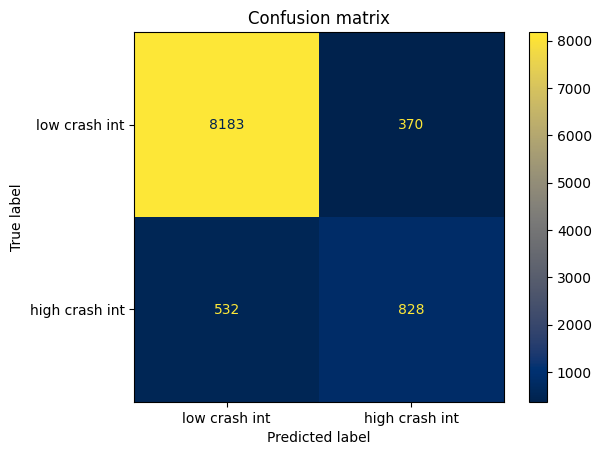



____________________________________________________________________________________________________




In [ ]:
from sklearn.metrics import f1_score
#make prediction, low = 0 and high =1
y_pred_gboost = best_gboost_model.predict(X_test_ohe)

#computing metrics to evaluate the model on the test set and then computing them on the train to asses overfitting

#Accuracy on TEST data -- model evaluation
print("Accuracy: {}".format(best_gboost_model.score(X_test_ohe, y_test)))
print("Average Accuracy with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean())) 
print("STD Accuracy with cross val in the tes set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std())) 

#MEAN e STD of on Accuracy on TRAIN data -- check under/overfitting
print("Average Accuracy with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean()))
print("Average Accuracy with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std()))

print("Precision score: {}".format(precision_score(y_test, y_pred_gboost)))
print("Recall score:    {}".format(recall_score(y_test, y_pred_gboost)))

#F1 score on TEST data -- model evaluation
print("F1 Score:{}\n".format(f1_score(y_test, y_pred_gboost)))
print("Average F1 Score with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean())) 
print("Std F1 Score with cross val in the test set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))

#MEAN e STD of on Accuracy on test data -- check under/overfitting
print("Average  F1score with cross val in the training ning set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean()))
print("STD F1score with cross val in the training set, evaluate overfitting: {}".format(cross_val_score(best_gboost_model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))


print("Report:\n", classification_report(y_test, y_pred_gboost,digits=6), "\n")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gboost, cmap='cividis', display_labels=["low crash int","high crash int"])
plt.title("Confusion matrix")
plt.show()
print("\n")
print("_"*100)
print("\n")

In [ ]:
prob_a_gboost = best_gboost_model.predict_proba(X_test_ohe)[:,1]

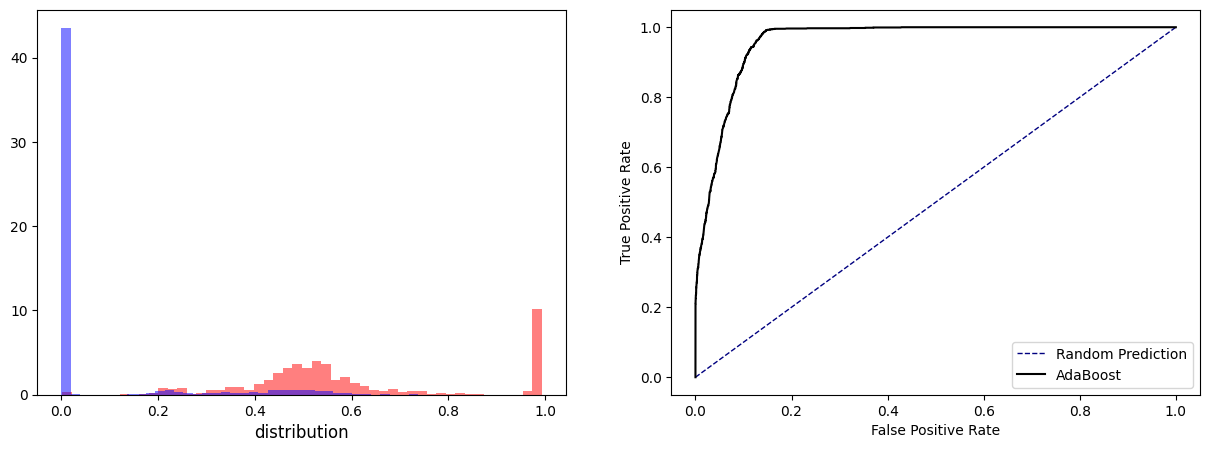

AUC Score :  0.9600201339743193


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
fig , ax = plt.subplots(1,2, figsize = (15,5))

high_distr = prob_a_gboost[y_test==1]
low_distr = prob_a_gboost[y_test==0]
ax[0].hist(high_distr, color="red", density=True, alpha=0.5, bins=50)
ax[0].hist(low_distr, color="blue", density=True, alpha=0.5, bins=50)
ax[0].set_xlabel("score", fontsize=12)
ax[0].set_xlabel("distribution", fontsize=12)

lr_auc=roc_auc_score(y_test, prob_a_gboost)
lr_fpr,lr_tpr, thresholds =roc_curve(y_test, prob_a_gboost)

ax[1].plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
ax[1].plot(lr_fpr,lr_tpr , color="black" , label='AdaBoost')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)

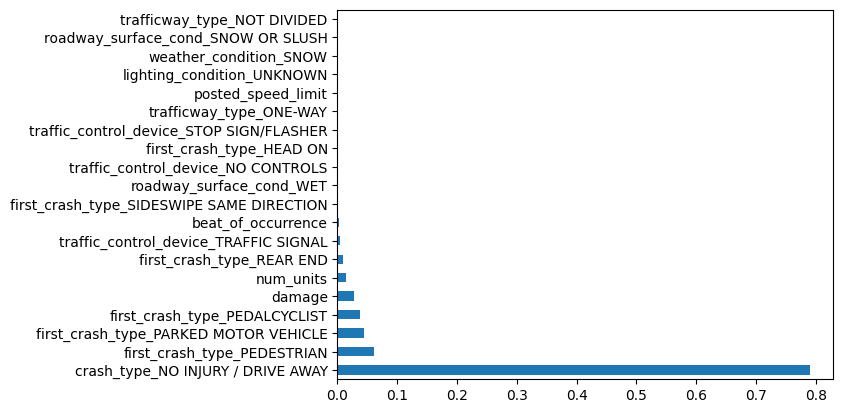

In [ ]:
feat_importances_gboost = pd.Series(best_gboost_model.feature_importances_, index= X_train_ohe.columns)
feat_importances_gboost.nlargest(20).plot(kind='barh')
plt.show()

<br>

### MODEL VALIDATION AND MODEL COMPARISON <br>

1. **Detecting overfitting** <br>
Overfitting regards models  that perform well on training, but has low perfomance on the test set. As model complexcity increases, in general performance on train data enhances, whilst performance on test data becomes lower. In order to prevent ans assess properly overfitting I carried out:
- Stratified k-fold cross validation with GridSearch to estimate as much robustly as possible the (hyper)parameters, and then I evaluated the metrics performance both in train and test. I harvested Accuracy, F1score, their average and std on the crossvalidation. Then I tested both in the training set and in the test set. <br>

In all models we can see performance metrics remain consistent across different folds, it suggests that the model is generalizing well and not overfitting.
Moreover, models performs well on both datasets without a significant gap between them, neither on average nor in standard deviation. This indicates that the models are likely not overfitting. <br>


<br>

2. **Comparison with quasi Random classifier** <br>

When validate a model, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. This classifier serves as a simple baseline to compare against other more complex classifiers.
DummyClassifier makes predictions that ignore the input features.The specific behavior of the baseline is selected with the strategy parameter, I selected "stratified" that  generates random predictions by respecting the training set class distribution.

In [ ]:
#confronto con un modello semi casuale
from sklearn.dummy import DummyClassifier

model_trivial = DummyClassifier(strategy="stratified",random_state=42)
model_trivial.fit(X_train_ohe, y_train)
score = model_trivial.score(X_test_ohe, y_test)


predict = model_trivial.predict(X_test_ohe)
print('Dummy Classifier model performance metrics')
print("Accuracy: {}".format(accuracy_score(y_test, predict)))
print("F1 score:    {}".format(f1_score(y_test, predict)))
print("Precision score: {}".format(precision_score(y_test, predict)))
print("Recall score:    {}".format(recall_score(y_test, predict)))
print(classification_report(y_test, predict, digits=5))  
print

Dummy Classifier model performance metrics
Accuracy: 0.7673761727025119
F1 score:    0.13697604790419163
Precision score: 0.13948170731707318
Recall score:    0.13455882352941176
              precision    recall  f1-score   support

           0    0.86316   0.86800   0.86557      8553
           1    0.13948   0.13456   0.13698      1360

    accuracy                        0.76738      9913
   macro avg    0.50132   0.50128   0.50127      9913
weighted avg    0.76387   0.76738   0.76561      9913



<function print(*args, sep=' ', end='\n', file=None, flush=False)>

## Model evaluation and model selction

As a 'data scientist' of an insurance company, when my model makes a mistake in classification, **I would prefer my model precidicts a low intensity crash as high intensity one, rather than the opposite**. 
The reason is that my reasearch can be useful to identify the crash severity of a place which has similar characteristics as the features.

As an insurance company, our financial stability relies heavily on accurately assessing and pricing insurance policies. 

Moreover, the severity of crashes directly influences the frequency and magnitude of claims that must be reimbursed. By predicting a slightly higher number of high-intensity crashes as compared to low-intensity ones, we can justify charging higher premiums for insurance policies, thereby ensuring that the company remains financially robust and capable of meeting its obligations.

In [ ]:
#logistic performance metrics
probability_logistic_test = model.predict(X_test_ohe)

print('Dummy Classifier model performance metrics')
print("Accuracy: {}".format(accuracy_score(y_test, probability_logistic_test)))
print("F1 score:    {}".format(f1_score(y_test, probability_logistic_test)))
print("Precision score: {}".format(precision_score(y_test, probability_logistic_test)))
print("Recall score:    {}".format(recall_score(y_test, probability_logistic_test)))
print(classification_report(y_test, predict, digits=5))  

Dummy Classifier model performance metrics
Accuracy: 0.8913547866438011
F1 score:    0.3452887537993921
Precision score: 0.9964912280701754
Recall score:    0.2088235294117647
              precision    recall  f1-score   support

           0    0.86316   0.86800   0.86557      8553
           1    0.13948   0.13456   0.13698      1360

    accuracy                        0.76738      9913
   macro avg    0.50132   0.50128   0.50127      9913
weighted avg    0.76387   0.76738   0.76561      9913



Model: Gradient Boosting
Accuracy: 0.9090083728437406


Average Accuracy with cross validation on TEST set to evaluate overfitting: 0.9093109798575479
STD Accuracy with cross validation on TEST set to evaluate overfitting: 0.006788585840460722
Average Accuracy with cross validation on TRAIN set to evaluate overfitting: 0.9102945311890084
STD Accuracy with cross validation on TRAIN set to evaluate overfitting: 0.0015777341419396826
Precision score: 0.6911519198664441
Recall score:    0.6088235294117647
F1 Score: 0.6473807662236122
Average F1 Score with cross validation on TEST set to evaluate overfitting: 0.6438470814440893
Std F1 Score with cross validation on TEST set to evaluate overfitting: 0.021312639658594826
Average F1 Score with cross validation on TRAIN set to evaluate overfitting: 0.6523174970815142
STD F1 Score with cross validation on TRAIN set to evaluate overfitting: 0.006542598468749747
Classification Report:
               precision    recall  f1-score   support

           0   0.938956  0.956740  0.947765      8553
         

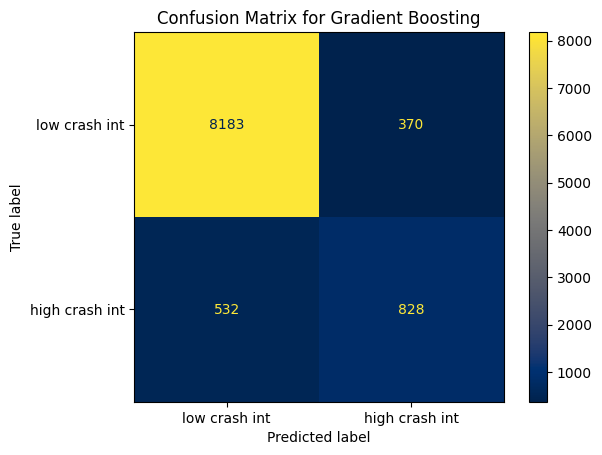


 ____________________________________________________________________________________________________ 

Model: AdaBoost
Accuracy: 0.9032583476243317
Average Accuracy with cross validation on TEST set to evaluate overfitting: 0.9036623611494881
STD Accuracy with cross validation on TEST set to evaluate overfitting: 0.005319375972224011
Average Accuracy with cross validation on TRAIN set to evaluate overfitting: 0.9047210468983508
STD Accuracy with cross validation on TRAIN set to evaluate overfitting: 0.0010410285396054778
Precision score: 0.691866028708134
Recall score:    0.5316176470588235
F1 Score: 0.6012474012474013
Average F1 Score with cross validation on TEST set to evaluate overfitting: 0.6272097506200474
Std F1 Score with cross validation on TEST set to evaluate overfitting: 0.013468019495457551
Average F1 Score with cross validation on TRAIN set to evaluate overfitting: 0.6123339900188356
STD F1 Score with cross validation on TRAIN set to evaluate overfitting: 0.005099463750

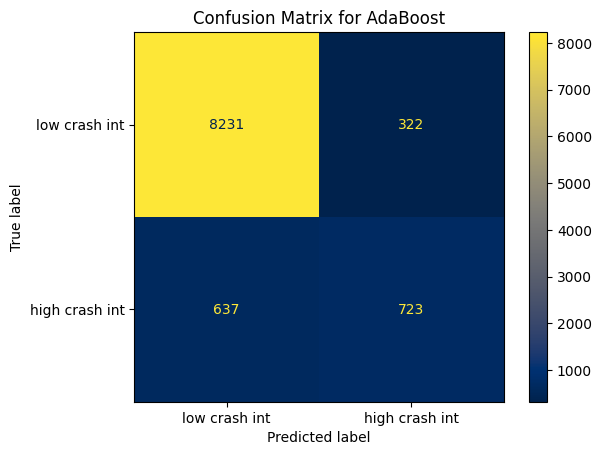


 ____________________________________________________________________________________________________ 

Model: Random Forest
Accuracy: 0.8913547866438011
Average Accuracy with cross validation on TEST set to evaluate overfitting: 0.8894382269472147
STD Accuracy with cross validation on TEST set to evaluate overfitting: 0.004438150677200012
Average Accuracy with cross validation on TRAIN set to evaluate overfitting: 0.8953142226228332
STD Accuracy with cross validation on TRAIN set to evaluate overfitting: 0.002076567700197957
Precision score: 0.9964912280701754
Recall score:    0.2088235294117647
F1 Score: 0.3452887537993921
Average F1 Score with cross validation on TEST set to evaluate overfitting: 0.3245106911339025
Std F1 Score with cross validation on TEST set to evaluate overfitting: 0.039304015517673395
Average F1 Score with cross validation on TRAIN set to evaluate overfitting: 0.3832095759464381
STD F1 Score with cross validation on TRAIN set to evaluate overfitting: 0.0203892

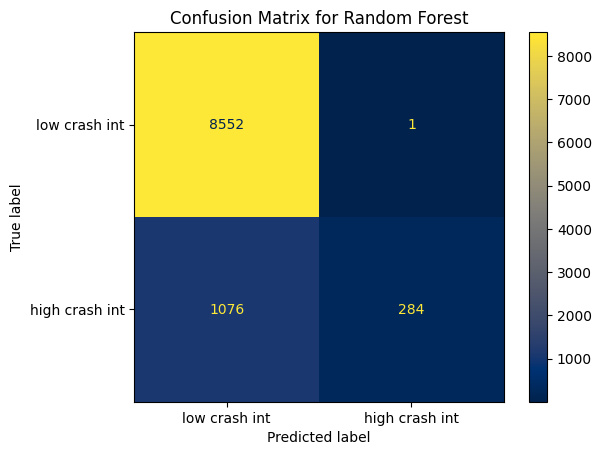


 ____________________________________________________________________________________________________ 



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Lista dei migliori modelli e relative predizioni
best_models = [best_gboost_model, best_ada_model, best_rf_model]
prediction_models = [y_pred_gboost, y_pred_ada, y_pred_rf]
model_names = ["Gradient Boosting", "AdaBoost", "Random Forest"]

# Loop sui modelli
for model, pred, model_name in zip(best_models, prediction_models, model_names):
    print("Model:", model_name)
    
    # Accuracy sul set di TEST
    print("Accuracy: {}".format(accuracy_score(y_test, pred)))
    print("Average Accuracy with cross validation on TEST set to evaluate overfitting: {}".format(
        cross_val_score(model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean()))
    print("STD Accuracy with cross validation on TEST set to evaluate overfitting: {}".format(
        cross_val_score(model, X_test_ohe, y_test, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std()))

    # Accuracy sul set di TRAIN
    print("Average Accuracy with cross validation on TRAIN set to evaluate overfitting: {}".format(
        cross_val_score(model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').mean()))
    print("STD Accuracy with cross validation on TRAIN set to evaluate overfitting: {}".format(
        cross_val_score(model, X_train_ohe, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise').std()))
    
    # Precision e Recall
    print("Precision score: {}".format(precision_score(y_test, pred)))
    print("Recall score:    {}".format(recall_score(y_test, pred)))

    # F1 score sul set di TEST
    print("F1 Score: {}".format(f1_score(y_test, pred)))
    print("Average F1 Score with cross validation on TEST set to evaluate overfitting: {}".format(
        cross_val_score(model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean()))
    print("Std F1 Score with cross validation on TEST set to evaluate overfitting: {}".format(
        cross_val_score(model, X_test_ohe, y_test, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))

    # F1 score sul set di TRAIN
    print("Average F1 Score with cross validation on TRAIN set to evaluate overfitting: {}".format(
        cross_val_score(model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').mean()))
    print("STD F1 Score with cross validation on TRAIN set to evaluate overfitting: {}".format(
        cross_val_score(model, X_train_ohe, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise').std()))

    # Classification report
    print("Classification Report:\n", classification_report(y_test, pred, digits=6), "\n")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='cividis', display_labels=["low crash int", "high crash int"])
    plt.title("Confusion Matrix for " + model_name)
    plt.show()

    print("\n", "_"*100, "\n")


<br>

3.  **The Best Model and performance metrics** 
<br>
        According the motivations explained beforehands, I want to keep as minimun as possible **False Negative**, in this case the **"False High Severity"** (Predicted 0, True label 1) have a crucial role and so I prefer **Recall** than precision. <br>

        Acuracy remains steady around 90% for each models, thus it's not particularly informative, especially if we bear in mind our dataset is quite unbalanced. Indeed, 86% of the data are low intensity crashes, hence 90% is not an astonishing result. This further shed the light on the fact that other metrics should be employed in this model evaluation.

        In conclusion, according to `Recall`:
- `Gradient Boosting` is undoubtely the best model with a `recall_score = 0.608`, that is prefered to `AdaBoost` that shows a recall of 0.53. 
Remaining models, `Random Forest` and `Logistic Regression` exhibits a recall value that barely arrive to 0.2 and that is not too far from the `Dummy model`.
The finding is underpinned by the distribution plot of the prediction of each model and from the Confusion matrices. Indeed, the red histograms and the cell of False negative of the confusion matrix outline that 'Gradient Boosting' is the one that predicts with more attention the class = 1.

<br>

4.  **Features Importance**

 Feature importance is significant in machine learning because it provides insights into which features  have the most influence on the model's predictions.
 
- It offers model Interpretability, debugging and diagnosis, compelling for explaining to clients can better understand the factors driving the predictions, leading to increased trust and acceptance of the model's decisions.
- Feature importance graphs point out that `Gradient Boosting` and `Random Forest` tend to assign more importance to the same varibles, e.g. **crash_type**, **first type crash**,**num_unit**. Onthe other hand, `AdaBoost` allocates more weight to **beat of occurence** and **posted_limit_speed**. 

<br>

### Some REMARKS AND MODEL IMPROVEMENT

In spite of a dataset with quite unbalanced classes, we managed to obtain a final model capable of classifying with an acceptable margin of error the crash severity.  Furthermore, through the evaluation of the models we were able to confirm all the assumptions described in the exploratory analysis phase. The features importance were close to the most relevant feature histograms (with respect to the target varaible) we showed beforehand.

So far, some model improvement might be: 
1. Considering some advanced libraries for hyperparameter tunining explainability as Optuna
2. Using **Shap** (since we are working with trees) libraries to further understand feature importance, and use it for refine the feature selection process factoring out less important features, thereby simplify models, reduce overfitting, and improve generalization performance.
3. Striving to apply some oversamplimng techniques like SMOTE and fit again the models, bearing in mind that they are synthetics data though.
4. Implement some advanced bagging models like **XGBOOST** and **CATBOOST**


.

.

## XGBOOST

- **It allows only float, int, boolean data type. In this case label encoding on damage made it an object type, hence let's convert it to numeric.**

- **Moreover, to use categorical data we should do OHE beforehand.** <be> **For Missing values or NaN, we may replace them with zero, do OHE and XGBoost will consider them as missing values internally. This does not allocate mamory since the algorithm considere just sparse matrices**

**Tips** <br> If you wanna print out the tree at the end make sure the categorical data (that may be are not encoded) does not have a blanck space between two words. Like Città del Messico must be Città_del_messico. You can do that with df.replace('','_', regex=True, inplace=True)

In [ ]:
X_train_ohe['damage'] = pd.to_numeric(X_train_ohe['damage'])
X_test_ohe['damage'] = pd.to_numeric(X_test_ohe['damage'])

In [ ]:
#definin the model
import warnings
warnings.filterwarnings("ignore")

clf_xgb = xgb.XGBClassifier(verbose=False, eval_metric='aucpr')
clf_xgb.fit(X_train_ohe, y_train, early_stopping_rounds=20, eval_set=[(X_test_ohe, y_test)])


In [ ]:
pred = clf_xgb.predict(X_test_ohe)

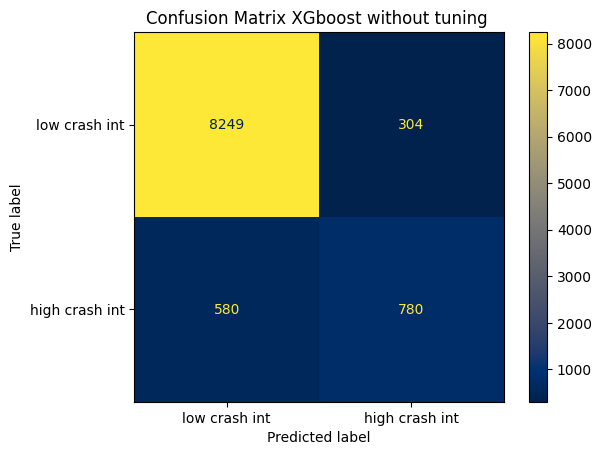

 Accuracy on test basic XGboost: 0.9108241702814486


Average Accuracy with cross validation on TRAIN set to evaluate overfitting: 0.907293451415686
Recall score:    0.5735294117647058
Classification Report:
               precision    recall  f1-score   support

           0   0.934307  0.964457  0.949143      8553
           1   0.719557  0.573529  0.638298      1360

    accuracy                       0.910824      9913
   macro avg   0.826932  0.768993  0.793720      9913
weighted avg   0.904845  0.910824  0.906497      9913
 



In [ ]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low crash int", "high crash int"])
disp.plot(cmap='cividis')
plt.title("Confusion Matrix XGboost without tuning " )
plt.show()

print(" Accuracy on test basic XGboost: {}".format(accuracy_score(y_test, pred)))
print("Average Accuracy with cross validation on TRAIN set to evaluate overfitting: {}".format(
        cross_val_score(clf_xgb, X_train_ohe, y_train, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise').mean()))
print("Recall score:    {}".format(recall_score(y_test, pred)))


# Classification report
print("Classification Report:\n", classification_report(y_test, pred, digits=6), "\n")


- ` Extreme Gradient Boosting` has the highest accuracy, but we're intereste mainly on recall, therefore let's see if we can do better with cross validation. The "best" model remains with ` Gradient Boosting` with a `recall_score = 0.608`.

The good news is that XGB has **scale_pos_weight** that helps accounting for quite unbalanced dataset.

## XGboost with Cross Validation

#### Main XGBoost Hyperparameters

- **n_estimators** 
- **learning_rate**: Lower values make the model more robust but require more trees to achieve good performance.
- **max_depth**: Higher values can lead to overfitting.

- **subsample**: Subsample ratio of the training instances.Values less than 1 lead to bagging, reducing overfitting risk.

- **colsample_bytree**: Subsample ratio of columns when constructing each tree.
 Controls variability across trees. Lower values reduce overfitting risk.

- **gamma**:Minimum loss reduction required to make a further partition on a leaf node.Higher values increase regularization.

- **reg_alpha** and **reg_lambda**: L1 and L2 regularization terms on tree weights. Regularize tree weights to prevent overfitting.

- **objective**:Loss function to be optimized, e.g., 'reg:linear' for linear regression, 'binary:logistic' for binary classification



- I will select the best HP in two rounds to speed up the computation. Based on the results in the fist round i will adjust HP values in that direction. It means that if 'reg_lambda': [0,1,10] and the best model has **reg_lambda** = 10, it makes no sense still incluiding 0, 1 and the next round of gridsearch meay contains 'reg_lambda': [10, 20, 50]

In [ ]:
%%time
#Second Cycle of Gridsearch for HP tuning

param_grid = {
                'max_depht':[3,4,5],
                'eta':[0.1, 0.01, 0.05],            #learning_rate
                'gamma':[0, 0.25, 1],
                'reg_lambda': [0,1,10],             #default=1, see lib
                'xgb__n_estimators':  [150,300]     
}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

#GridSearch with Stratified K-fold cross validation
grid_xgb = GridSearchCV(clf_xgb, param_grid, cv = skf, scoring='recall')

#fitting the model
grid_xgb.fit(X_train_ohe, y_train)

In [91]:
#store the result of the fitted gb
result_xgb = pd.DataFrame(grid_xgb.cv_results_)

#get the best model from gs_gboost
best_rf_params = result_xgb.sort_values("rank_test_score").iloc[0:5, 4:9]
best_rf_params


param_eta param_gamma param_max_depht param_reg_lambda  \
98       0.01           1               4                1   
99       0.01           1               4                1   
44        0.1           1               4                1   
45        0.1           1               4                1   
146      0.05           1               3                1   

    param_xgb__n_estimators  
98                      150  
99                      300  
44                      150  
45                      300  
146                     150

In [100]:
best_xgb_model = grid_xgb.best_estimator_

In [111]:
from sklearn.metrics import f1_score
#make prediction, low = 0 and high =1
#EVALUATING OVERFITTING AND GENERALIZED PERFORMANCE
y_pred_xgb = best_xgb_model.predict(X_test_ohe)
y_pred_xgb_train = best_xgb_model.predict(X_train_ohe)

print("Accuracy test: {}".format(best_xgb_model.score(X_test_ohe, y_test)))
print("Precision score test: {}".format(precision_score(y_test, y_pred_xgb)))
print("Recall score test:    {}".format(recall_score(y_test, y_pred_xgb)))
print("F1 Score test:{}\n".format(f1_score(y_test, y_pred_xgb)))

print("Accuracy train: {}".format(best_xgb_model.score(X_train_ohe, y_train)))
print("Recall score train:    {}".format(recall_score(y_train, y_pred_xgb_train)))
print("F1 Score train:{}\n".format(f1_score(y_train, y_pred_xgb_train)))





Accuracy test: 0.9071925754060325
Precision score test: 0.6746031746031746
Recall score test:    0.625
F1 Score test:0.6488549618320612

Accuracy train: 0.9227277312619793
Recall score train:    0.6752482530342038
F1 Score train:0.7056110684089162



Report:
               precision    recall  f1-score   support

           0   0.941061  0.952064  0.946530      8553
           1   0.674603  0.625000  0.648855      1360

    accuracy                       0.907193      9913
   macro avg   0.807832  0.788532  0.797693      9913
weighted avg   0.904505  0.907193  0.905691      9913
 



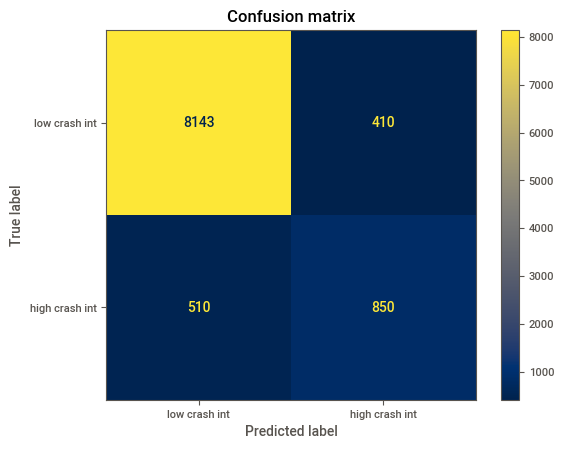



____________________________________________________________________________________________________




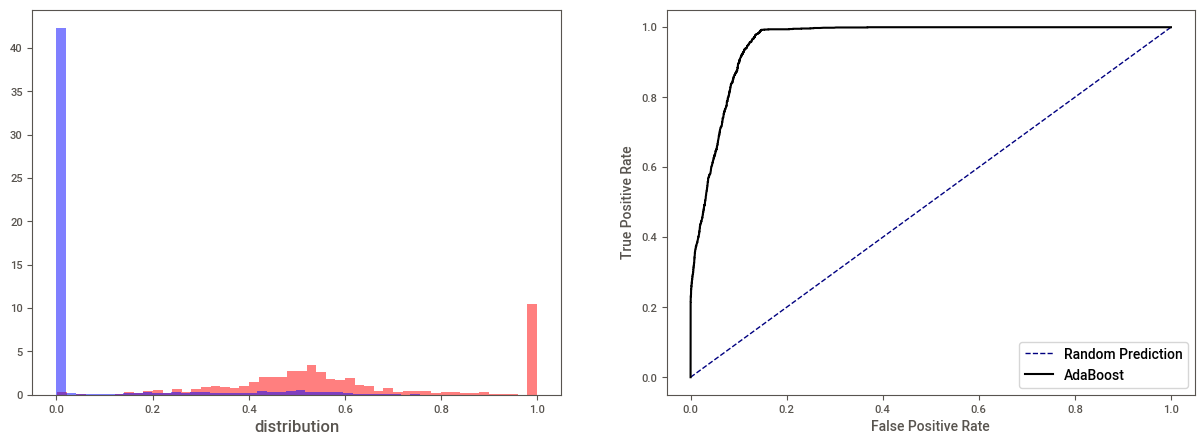

AUC Score :  0.9589882892827422


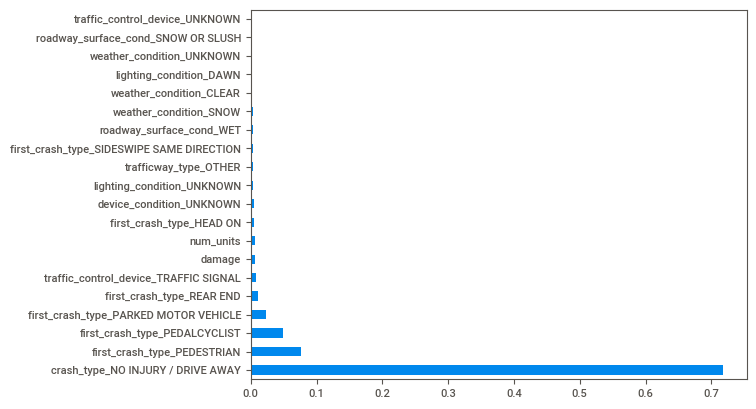

In [112]:
print("Report:\n", classification_report(y_test, y_pred_xgb,digits=6), "\n")
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='cividis', display_labels=["low crash int","high crash int"])
plt.title("Confusion matrix")
plt.show()
print("\n")
print("_"*100)
print("\n")
prob_a_xgb = best_xgb_model.predict_proba(X_test_ohe)[:,1]
from sklearn.metrics import roc_auc_score, roc_curve
fig , ax = plt.subplots(1,2, figsize = (15,5))

high_distr = prob_a_xgb[y_test==1]
low_distr = prob_a_xgb[y_test==0]
ax[0].hist(high_distr, color="red", density=True, alpha=0.5, bins=50)
ax[0].hist(low_distr, color="blue", density=True, alpha=0.5, bins=50)
ax[0].set_xlabel("score", fontsize=12)
ax[0].set_xlabel("distribution", fontsize=12)

lr_auc=roc_auc_score(y_test, prob_a_xgb)
lr_fpr,lr_tpr, thresholds =roc_curve(y_test, prob_a_xgb)

ax[1].plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
ax[1].plot(lr_fpr,lr_tpr , color="black" , label='AdaBoost')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)
feat_importances_gboost = pd.Series(best_xgb_model.feature_importances_, index= X_train_ohe.columns)
feat_importances_gboost.nlargest(20).plot(kind='barh')
plt.show()




In [ ]:
import shap

explainer = shap.TreeExplainer(best_xgb_model, model_output="raw")
shap_values = explainer.shap_values(X_test_ohe)

shap_values.shape

(9913, 85)

## Shap vs Sklearn features importance.

Shap values confirm what feature importance of Sklearn told us. Shap is a more accurate way to asses feature importance.  <br>
- Sklearn measures how much each feature decreases the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on **AVERAGE** it decreases the impurity. The **AVERAGE** over all trees in the forest is the measure of the feature importance
- Shap utilizes game theory to calculate feature importance based on the marginal contributions of features to each prediction. In addiction from the second plot we can also se the 'direction of a feature', namely if a feature increases what is the effect on the target variable? This is not possible with Sklearn.

##### ADVANTAGES OF SHAP
- The difference between the prediction and the average prediction is fairly distributed among the feature values of the instance by the Efficiency property of Shapley values.This property distinguishes the Shapley value from other methods such as LIME and Sklearn fi. LIME does not guarantee that the prediction is fairly distributed among the features
- The Shapley value allows contrastive explanations. Instead of comparing a prediction to the average prediction of the entire dataset, you could compare it to a subset or even to a single data point
- The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data (see below)
- SHAP has a fast implementation for tree-based models



##### DISADVANTAGES OF SHAP
- SHAP is slow. This makes KernelSHAP impractical to use when you want to compute Shapley values for many instances. Also all global SHAP methods such as SHAP feature importance require computing Shapley values for a lot of instances.
- It is possible to create intentionally misleading interpretations with SHAP, which can hide biases 73. If you are the data scientist creating the explanations, this is not an actual problem (it would even be an advantage if you are the evil data scientist who wants to create misleading explanations). For the receivers of a SHAP explanation, it is a disadvantage: they cannot be sure about the truthfulness of the explanation.


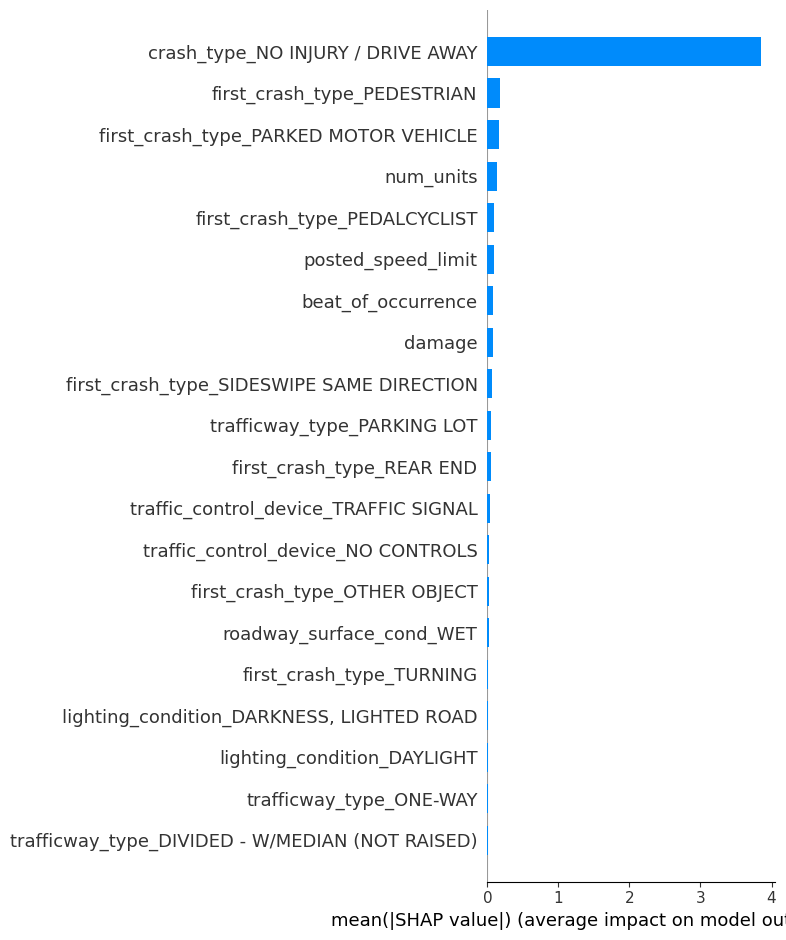

In [ ]:
shap.summary_plot(shap_values,X_test_ohe , plot_type="bar")

- From this plot we can notice(feature are ordered by importance):
    - 1. **No Injury Drive away** is the most important features. When it increases(so the people don't drive away and there are no injuries) it pushes the outcomes toward zero, ie low crash severity.
    - 2. **crash type PEDASTRIAN** and **crash motor vehicle** when they increase, the probability is pushed toward 1 and so we have high probability to have a crash with high severity.

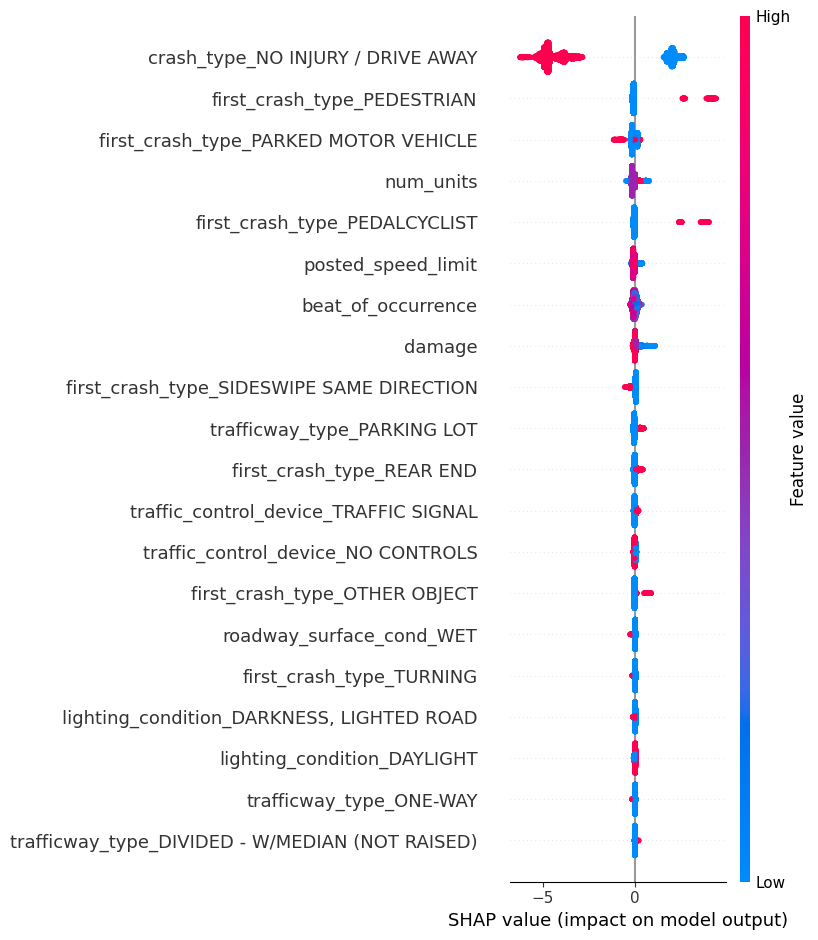

In [ ]:
shap.summary_plot(shap_values, X_test_ohe)

## CATBOOST

**CatBoost** is gradient boosting framework that is specifically designed for **categorical feature**. <br>

- **We have many categorical features, will it boost our generalized performance?** <br>

It doesn’t require extensive preprocessing like one-hot encoding or label encoding, as it can naturally handle categorical data. It employs techniques such as “ordered boosting” to make optimal decisions for categorical variables, which simplifies the feature engineering process and reduces the risk of data leakage.

Do not use **one-hot encoding** during preprocessing. This affects both the training speed and the resulting quality.Sometimes when categorical features don't have a lot of values, one-hot encoding works well.
This is what the offcial lib. page says.
https://catboost.ai/en/docs/concepts/parameter-tuning#one-hot-enc <br>

Will se in this example that there is no difference among the two methods.

#### CatBoost OHE vs CatBoost without OHE

In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool, cv

model_cb = CatBoostClassifier(verbose=False)
model_cb.fit(X_train_ohe, y_train)

**CB with OHE generalized performance**

In [ ]:
predcb= model_cb.predict(X_test_ohe)

#accuracy
acc_cb = model_cb.score(X_test_ohe, y_test)

#recall
rec_cb = recall_score(y_test, predcb)

print("Accuracy: {:.2f}".format(acc_cb))
print("Recall: {:.2f}".format(rec_cb))

Accuracy: 0.91
Recall: 0.62


**CB without OHE generalized performance**

In [ ]:
cat_features = ['traffic_control_device', 'device_condition',
        'weather_condition', 'lighting_condition', 'first_crash_type',
        'trafficway_type', 'roadway_surface_cond', 'crash_type', 'damage']
type(cat_features)

list

In [ ]:
#X_train is the dataset without OHE
#with this method is slower than with OHE
%%time

model_cb2 = CatBoostClassifier()
model_cb2.fit(X_train, y_train, cat_features = cat_features)

In [ ]:
#I could not use predict to X_test without ohe, only fit
predcb2= model_cb.predict(X_test_ohe)

#accuracy
acc_cb2 = model_cb.score(X_test_ohe, y_test)

#recall
rec_cb2 = recall_score(y_test, predcb)

print("Accuracy: {:.2f}".format(acc_cb2))
print("Recall: {:.2f}".format(rec_cb2))

Accuracy: 0.91
Recall: 0.62


**This example shows, that in this case is better carrying out OHE since it's faster to fit and there not difference ito generalized performance**

### CatBoost with Cross validation

In [26]:
params = {'iterations':2000,
        'learning_rate': 0.02,
        'l2_leaf_reg': 5,
        'depth':4,
        'eval_metric':'Recall',
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        
          }

cat_model_2 = CatBoostClassifier(**params, verbose=False)
cat_model_2.fit(X_train_ohe, y_train,   
          eval_set=(X_test_ohe, y_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True  
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
dval_predictions = cat_model_2.predict(X_test_ohe)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Accuracy test: 0.9013416725511953
Accuracy train: 0.9040653687077574
Precision score: 0.5970528455284553
Recall test:    0.8639705882352942
Recall train: 0.9040653687077574
F1 Score:0.7061298076923078

Report:
               precision    recall  f1-score   support

           0   0.976715  0.907284  0.940720      8553
           1   0.597053  0.863971  0.706130      1360

    accuracy                       0.901342      9913
   macro avg   0.786884  0.885627  0.823425      9913
weighted avg   0.924628  0.901342  0.908536      9913
 



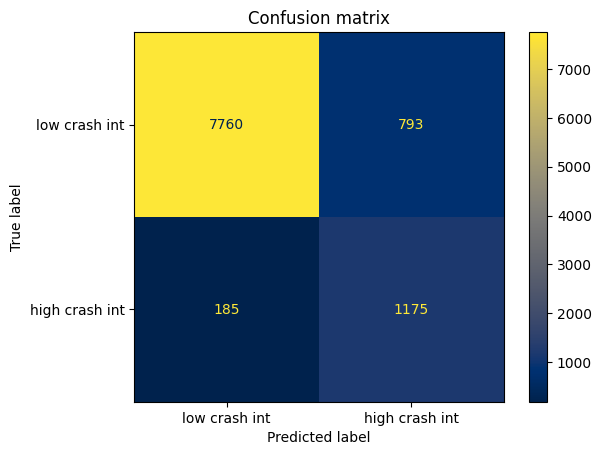



____________________________________________________________________________________________________




In [ ]:
#Accuracy on TEST data -- model evaluation
print("Accuracy test: {}".format(cat_model_2.score(X_test_ohe, y_test)))
print("Accuracy train: {}".format(cat_model_2.score(X_train_ohe, y_train)))


#prec and recall
print("Precision score: {}".format(precision_score(y_test, dval_predictions)))
print("Recall test:    {}".format(recall_score(y_test, dval_predictions)))
print("Recall train: {}".format(cat_model_2.score(X_train_ohe, y_train)))

#F1 score on TEST data -- model evaluation
print("F1 Score:{}\n".format(f1_score(y_test, dval_predictions)))



print("Report:\n", classification_report(y_test, dval_predictions,digits=6), "\n")
disp = ConfusionMatrixDisplay.from_predictions(y_test, dval_predictions, cmap='cividis', display_labels=["low crash int","high crash int"])
plt.title("Confusion matrix")
plt.show()
print("\n")
print("_"*100)
print("\n")


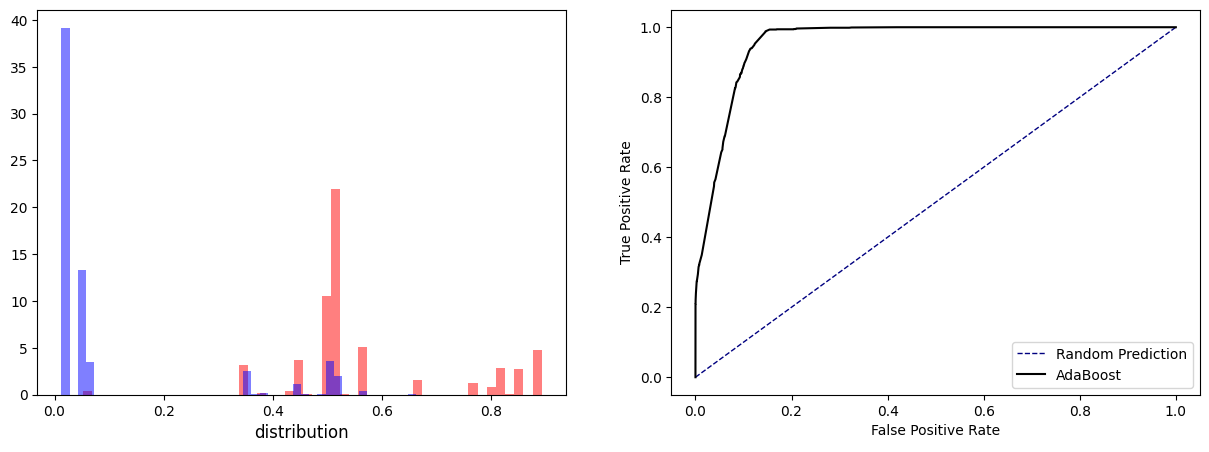

AUC Score :  0.9574065859244436


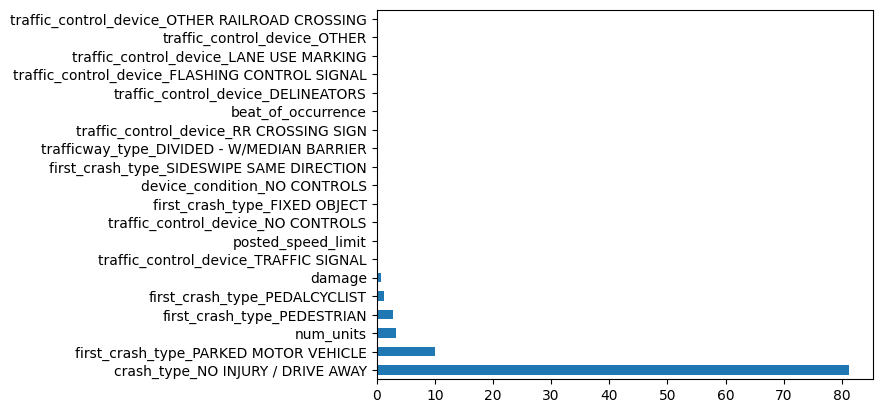

In [ ]:
prob_a_cat = cat_model_2.predict_proba(X_test_ohe)[:,1]
from sklearn.metrics import roc_auc_score, roc_curve
fig , ax = plt.subplots(1,2, figsize = (15,5))

high_distr = prob_a_cat[y_test==1]
low_distr = prob_a_cat[y_test==0]
ax[0].hist(high_distr, color="red", density=True, alpha=0.5, bins=50)
ax[0].hist(low_distr, color="blue", density=True, alpha=0.5, bins=50)
ax[0].set_xlabel("score", fontsize=12)
ax[0].set_xlabel("distribution", fontsize=12)

lr_auc=roc_auc_score(y_test, prob_a_cat)
lr_fpr,lr_tpr, thresholds =roc_curve(y_test, prob_a_cat)

ax[1].plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
ax[1].plot(lr_fpr,lr_tpr , color="black" , label='AdaBoost')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)
feat_importances_gboost = pd.Series(cat_model_2.feature_importances_, index= X_train_ohe.columns)
feat_importances_gboost.nlargest(20).plot(kind='barh')
plt.show()


## FINAL CONCLUSION

In spite of a dataset with quite unbalanced classes, we managed to obtain a final model capable of classifying with an acceptable margin of error the crash severity.
Furthermore, through the evaluation of the models we were able to confirm all the assumptions described in the exploratory analysis phase! <br>

### DISCLAIMER -- ATTENTION WHEN YOU SAID 'THE BEST MODEL IS'
Picking the best model is a tough task and requires a thoroughly examination of hyperparameter tuning/optimization, model assumptions, data structure and data prepocessing, evaluation of generalized metrics and much more. That is NOT carried out extensively and in NOT soat manner in this project, therefore final conclusion are always relative.



  3.  **The """"Best Model""" and generalized performance metrics** 
<br>
        According the motivations explained beforehands, I want to keep as minimun as possible **False Negative**, in this case the **"False High Severity"** (Predicted 0, True label 1) have a crucial role and so I prefer **Recall** than precision. <br>

        Acuracy remains steady around 90% for each models, thus it's not particularly informative, especially if we bear in mind our dataset is quite unbalanced. Indeed, 86% of the data are low intensity crashes, hence 90% is not an astonishing result. This further shed the light on the fact that other metrics should be employed in this model evaluation.

        In conclusion, according to `Recall`:
- `CATBOOST` is undoubtely the best model with a `recall_score = 0.86`, that is prefered to `XGBOOST` that shows a recall of 0.65. 
Remaining models, `Random Forest` and `Logistic Regression` exhibits a recall value that barely arrive to 0.2 and that is not too far from the `Dummy RANDOM model`.
The finding is underpinned by the distribution plot of the prediction of each model, Confusion matrices and Overfitting assessment. Indeed, the blu-red histograms and the cell of False negative of the confusion matrix outline that `CATBOOST` is the one that predicts with more attention the class = 1 and so it seems the most rebliable.

<br>

4.  **Features Importance**

 Feature importance is significant in machine learning because it provides insights into which features  have the most influence on the model's predictions.
 
- It offers model Interpretability, debugging and diagnosis, compelling for explaining to clients the factors driving the predictions, leading to increased trust and acceptance of the model's decisions.
- Feature importance graphs point out that `Gradient Boosting`, `Random Forest`, `XGBOOST`,`CATBOOST` tend to assign more importance to the same varibles, e.g. **crash_type**, **first type crash**,**num_unit**. Onthe other hand, `AdaBoost` allocates more weight to **beat of occurence** and **posted_limit_speed**. 
- Indeed, many fetures are not informative, hence we may carry out more performant models factoring out that features.

.

.

# Efficient way to code : <br> Project with Pipeline

- Pipelines in scikit-learn are powerful tools for organizing sequences of data transformations and machine learning models into a single object. They are useful for several reasons:

   1. Code Organization: Pipelines allow for clear and structured organization of the workflow, making the code easier to read and understand. <br>
   
    2. Automated Data Transformations: Pipelines automatically apply data transformations (such as standardization or normalization) to new data when passed through the pipeline.<br>

    3. Preventing Data Leakage: Pipelines ensure that data transformations are applied only to the training data during cross-validation, thus avoiding the risk of data leakage.<br>

    4. Ease of Reproducibility: Pipelines can be easily replicable and reusable across different datasets without having to rewrite the code from scratch.

In [139]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

Let's define **gs_describe fucntion** that computes the accuracy both in test and train set to assess overfitting and the best hp. <br>

Moreover, **grid_search_Xvalidation** carries out grid search and fit the model

In [173]:
def gs_describe(gs, score, X_train_ohe, y_train):
    pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

    print("Score on test:         {}".format(score))
    print("Score on train:              {}".format(gs.score(X_train_ohe, y_train))) # per controllo overfitting/underfitting
    print("Cross validation best score: {}".format(gs.best_score_))
    
    
    print("Best hyperparameters:    \n\n{}\n".format(pd.DataFrame(gs.best_params_)))

In [148]:
def grid_search_Xvalidation(model, grid, kf, X_train_ohe, X_test_ohe, y_train, y_test):
    gs = GridSearchCV(model, grid, cv=kf)
    gs.fit(X_train_ohe, y_train)
    score = gs.score(X_test_ohe, y_test)

    return gs, score

Let's create an empty dictionary **models** to store the best estimator and the score associated with it.

When you want to add an element to an empty dictionary in Python, you use the syntax `dictionary_name[key] = value`.

For example: `models["Random Forest"] = { "model": gs.best_estimator_, "score": score}` uses another dictionary as the value associated with a specific key ("Random Forest").

This approach is very flexible and allows for hierarchical organization of data.

In [149]:
models = {}

### LOGISTIC CROSS VALIDATION

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("logreg",  LogisticRegression(max_iter=200, random_state=42))
])

grid = {
    "scaler":           [ None, StandardScaler()],
    "logreg__penalty":  ["l2", "l1"],
    "logreg__C":        [1, 0.8, 0.3],
    
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train_ohe, X_test_ohe, y_train, y_test)
gs_describe(gs, score, X_train_ohe, y_train)

models["Logistic Regression"] = { "model": gs.best_estimator_, "score": score }

### RANDOM FOREST

In [162]:
%%time

model = Pipeline([
    ("scaler",        StandardScaler()),
    ("randomforest",  RandomForestClassifier())
])


grid = {
    "scaler":       [StandardScaler()],
    'randomforest__n_estimators': [ 10, 150, 200],
    'randomforest__max_depth': [4,5]
    
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train_ohe, X_test_ohe, y_train, y_test)
gs_describe(gs, score, X_train_ohe, y_train)


models["Random Forest"] = { "model": gs.best_estimator_, "score": score}

Score on test:         0.8894381115706648
Score on train:              0.893094925854938
Cross validation best score: 0.8945828511273343
Best hyperparameters:    

randomforest__max_depth                      5
randomforest__n_estimators                 200
scaler                        StandardScaler()
dtype: object

Wall time: 20.7 s


### XGBoost

In [171]:
%%time

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("xgb",     XGBClassifier())
])

grid = {
    'xgb__eta':           [0.1],
    'xgb__max_depth':     [4,5],
    'xgb__n_estimators':  [150, 300],
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train_ohe, X_test_ohe, y_train, y_test)
gs_describe(gs, score, X_train_ohe, y_train)

models["XGBoost"] = { "model": gs.best_estimator_, "score": score }

Score on test:         0.9079995964894583
Score on train:              0.9188187228891355
Cross validation best score: 0.909941444428711
Best hyperparameters:    

xgb__eta               0.1
xgb__max_depth         4.0
xgb__n_estimators    150.0
dtype: float64

Wall time: 57.8 s


- **models[model]["score"]** is a syntax for retrieving the score associated with a specific model in the models dictionary, which contains dictionaries as values.

In [176]:
for model in models:
    print("{:<20}:\t{:.6f}".format(model, models[model]["score"]))

Logistic Regression :	0.907495
Random Forest       :	0.889438
XGBoost             :	0.908000
